# ScholarSync - Reference Generation Tool
## Backend Infrastructure

**Purpose:** Core logic layer for automated reference generation from identifiers, titles, and PDF papers.

**Features:**
- Multi-identifier extraction (DOI, arXiv, PubMed)
- Crossref, arXiv, and PubMed API integration
- **Automatic abstract extraction** from all sources
- Intelligent fallback chain for papers without DOI
- Multi-style citation formatting (APA, MLA, Harvard, Chicago, IEEE, Vancouver)
- ML-based duplicate reference detection
- Complete reference package generation with caching


The flowchart below gives an overview of the entire process 

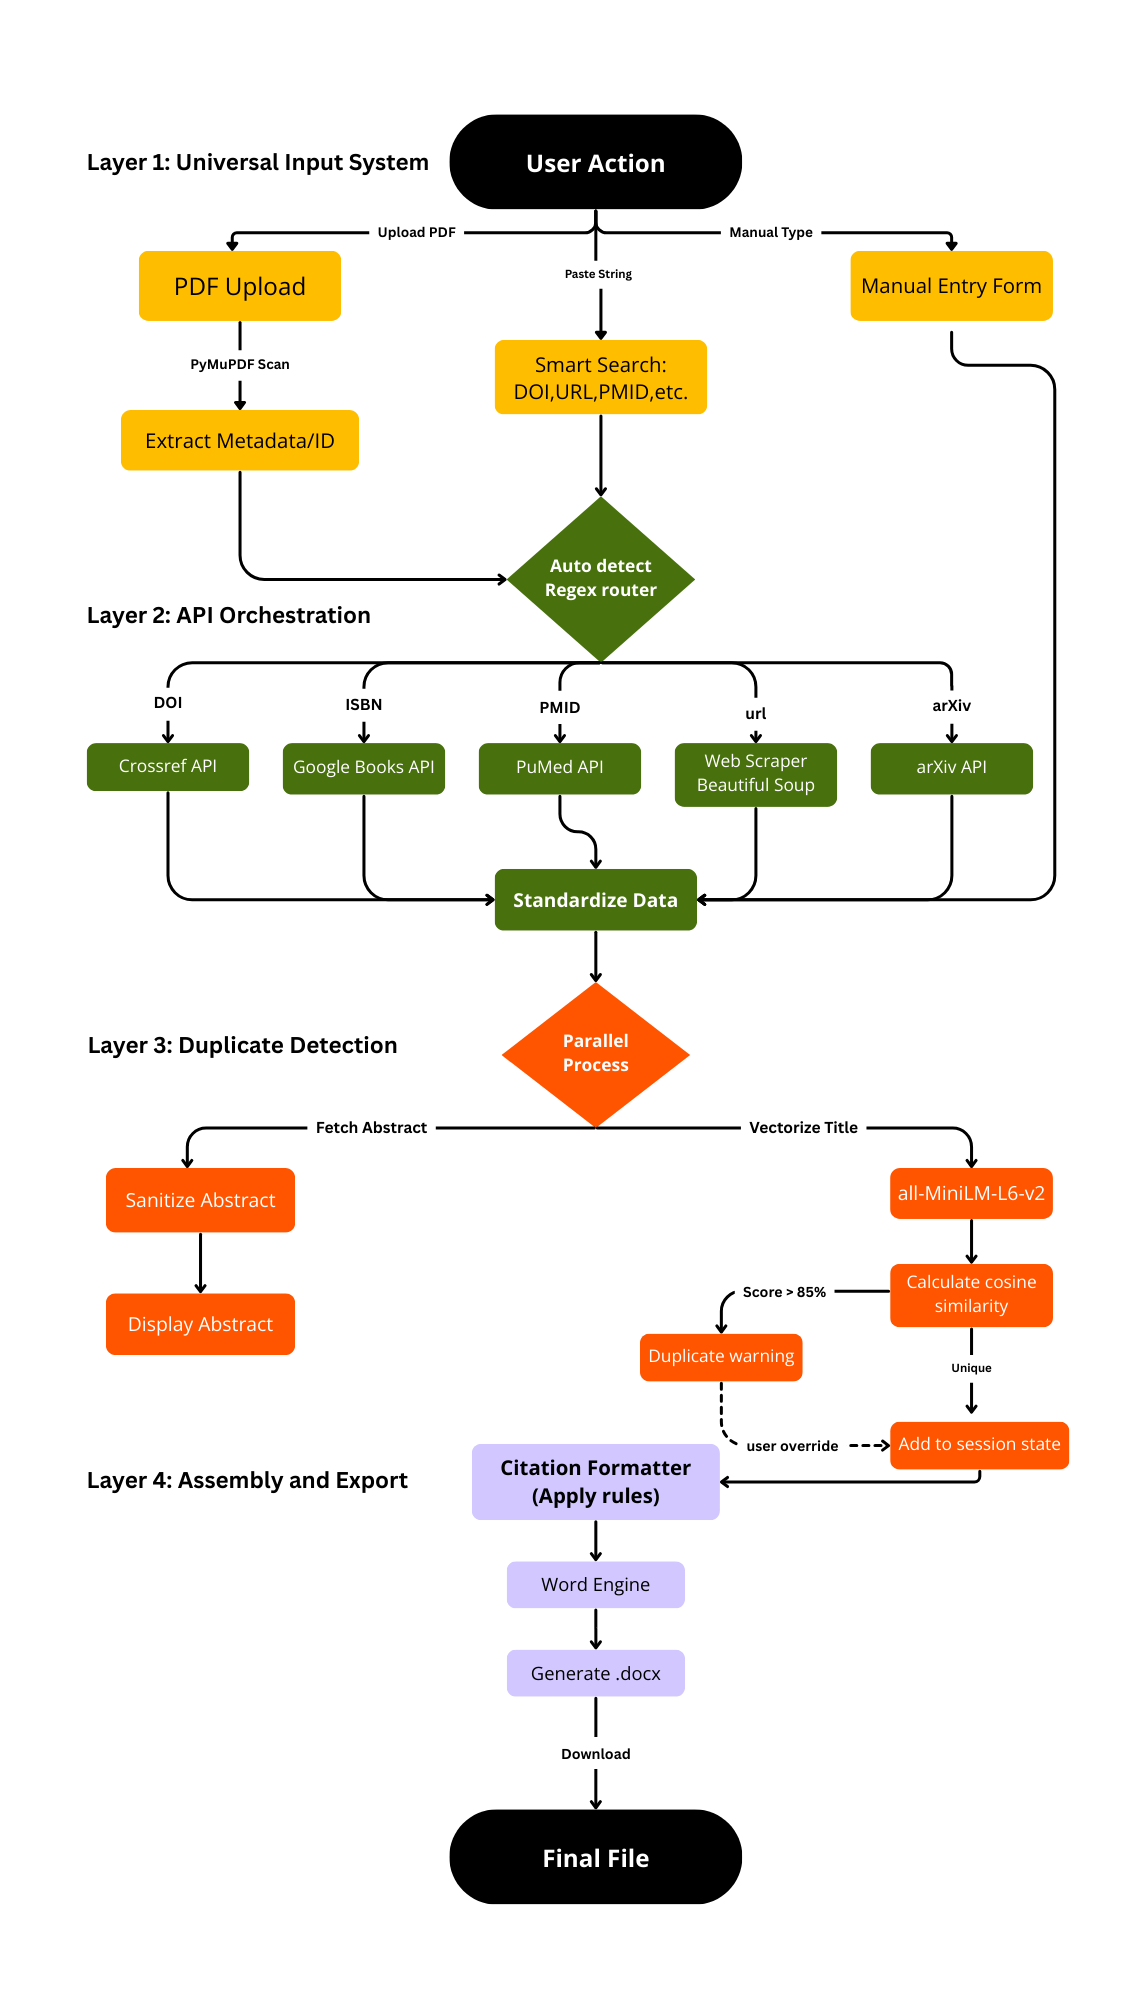

## 1. Setup & Dependencies

We install and import all required Python libraries for the reference generation system.

**What it does:**
- Installs external packages: `habanero` (Crossref API), `pymupdf` (PDF processing), `sentence-transformers` (ML duplicate detection)
- Imports standard libraries for HTTP requests, file handling, date/time operations
- Imports document generation library (`python-docx`) for Word export

**Run this first** before executing any other cells.

In [58]:
# 1: Setup & Dependencies
# Install required packages
%pip install habanero pymupdf requests python-docx sentence-transformers scikit-learn beautifulsoup4 matplotlib numpy

# Import all necessary libraries
import requests
import numpy as np
from habanero import Crossref
import fitz  # PyMuPDF
import re
from typing import Optional, Dict, Any, List, Tuple
import os
import time
import json
from datetime import datetime
from docx import Document
from docx.shared import Pt, Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from bs4 import BeautifulSoup
from urllib.parse import urlparse


print("✓ All dependencies loaded successfully!")

Note: you may need to restart the kernel to use updated packages.
✓ All dependencies loaded successfully!


## 2. Configuration

**Purpose:** Define global settings, supported citation styles, and API endpoints.

**What it does:**
- Maps citation styles (APA, MLA, Harvard, Chicago, IEEE, Vancouver) to their API codes
- Defines regex patterns for extracting identifiers (DOI, arXiv ID, PMID, PMCID) from text
- Sets API URLs for arXiv and PubMed services
- Configures retry logic (3 attempts with exponential backoff)
- Initializes in-memory cache for storing metadata

Run to load configurations.

In [59]:
# 2. Configuration
# Supported citation styles mapping (Display Name -> API Code)
SUPPORTED_STYLES: Dict[str, str] = {
    'APA': 'apa',
    'MLA': 'modern-language-association',
    'Harvard': 'harvard-cite-them-right',
    'Chicago': 'chicago-author-date',
    'IEEE': 'ieee',
    'Vancouver': 'vancouver'
}

# Regex patterns for identifier extraction
DOI_PATTERN: str = r'10\.\d{4,9}/[-._;()/:A-Z0-9]+[A-Z0-9]'
ARXIV_PATTERN: str = r'arXiv:\s*(\d{4}\.\d{4,5}(?:v\d+)?)'  # arXiv:2301.12345 or arXiv:2301.12345v1
PMID_PATTERN: str = r'PMID:\s*(\d{7,8})'  # PMID: 12345678
PMCID_PATTERN: str = r'PMC\s*(\d{6,7})'  # PMC1234567
ISBN_PATTERN: str = r'(?:ISBN[-: ]?)?(?:97[89][- ]?)?\d{1,5}[- ]?\d{1,7}[- ]?\d{1,7}[- ]?[\dX]'  # ISBN-10 or ISBN-13
URL_PATTERN: str = r'https?://(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&/=]*)'

# API endpoints for metadata retrieval of different identifiers
ARXIV_API_URL: str = "http://export.arxiv.org/api/query"
PUBMED_API_URL: str = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils"
GOOGLE_BOOKS_API_URL: str = "https://www.googleapis.com/books/v1/volumes"

# Retry configuration for API calls
MAX_RETRIES: int = 3
RETRY_DELAY: float = 1.0  # Initial delay in seconds
BACKOFF_FACTOR: float = 2.0  # Exponential backoff multiplier

# Cache for storing metadata results (in-memory)
METADATA_CACHE: Dict[str, Dict[str, Any]] = {}
print(f"✓ Configuration loaded")
print(f"  Supported styles: {', '.join(SUPPORTED_STYLES.keys())}")
print(f"  Supported identifiers: DOI, arXiv, PubMed (PMID/PMCID), ISBN, URL")
print(f"  Retry settings: Max {MAX_RETRIES} attempts with exponential backoff")

print(f"  Caching: Enabled")
print(f"  Abstract extraction: Enabled (API-based)")

✓ Configuration loaded
  Supported styles: APA, MLA, Harvard, Chicago, IEEE, Vancouver
  Supported identifiers: DOI, arXiv, PubMed (PMID/PMCID), ISBN, URL
  Retry settings: Max 3 attempts with exponential backoff
  Caching: Enabled
  Abstract extraction: Enabled (API-based)


## 3. Input Validation Module

**Purpose:** Validate and sanitize user inputs (DOIs, arXiv IDs, PMIDs, ISBNs, URLs, PDF files, titles) using regex pattern matching and format checks.

**How it works:**

### Validation Strategy
The module uses **regular expressions (regex)** to match input strings against predefined patterns for each identifier type:

- **DOI validation:** Uses regex pattern `^10\.\d{4,9}/[-._;()/:A-Z0-9]+$` to ensure DOIs start with "10." followed by 4-9 digits, a forward slash, and valid characters. The `re.match()` function checks if the entire string matches this pattern.

- **arXiv ID validation:** Uses pattern `^(arXiv:)?\d{4}\.\d{4,5}(v\d+)?$` to match formats like "2301.12345" or "2301.12345v1" with optional "arXiv:" prefix. The `?` indicates optional components.

- **PMID validation:** Pattern `^\d{7,8}$` ensures exactly 7-8 consecutive digits, representing valid PubMed identifiers.

- **PMCID validation:** Pattern `^PMC\d{6,7}$` requires "PMC" prefix followed by 6-7 digits.

- **ISBN validation:** Removes hyphens/spaces first, then validates with checksum algorithms:
  - *ISBN-10:* Uses weighted sum formula where each digit is multiplied by its position (10-i), and the total must be divisible by 11
  - *ISBN-13:* Alternates multipliers (1 and 3) for each digit, and the sum must be divisible by 10
  
- **URL validation:** Uses Python's `urlparse()` to verify the URL has a valid scheme (http/https) and network location (domain name).

- **PDF/Title validation:** Performs existence checks, file extension validation, size limits (50MB max), and content verification (title must be 3-500 characters with at least one letter).

### Sanitization Process
Each sanitizer function uses `re.sub()` to clean inputs:
- Removes common prefixes using patterns like `r'^(doi:|DOI:)\s*'` (matches "doi:" or "DOI:" at start with optional whitespace)
- Strips URL prefixes like "https://doi.org/" from DOI strings
- Normalizes case (converts PMCIDs to uppercase)
- Removes whitespace and special formatting

**Key functions:**
- `validate_doi()`, `validate_arxiv_id()`, `validate_pmid()`, `validate_pmcid()`, `validate_isbn()`, `validate_url()`
- `validate_pdf_file()`, `validate_title()`
- `sanitize_doi()`, `sanitize_arxiv_id()`, `sanitize_pmid()`, `sanitize_pmcid()`, `sanitize_isbn()`, `sanitize_url()`

This module ensures only properly formatted identifiers proceed to API calls, preventing errors and failed requests.

In [60]:
# 3. Input Validation Module

def validate_doi(doi: str) -> bool:
    """
    Validate DOI format using regex.
    
    Args:
        doi: String to validate as DOI
        
    Returns:
        True if valid DOI format, False otherwise
    """
    if not doi or not isinstance(doi, str):
        return False
    
    doi = doi.strip()
    pattern = r'^10\.\d{4,9}/[-._;()/:A-Z0-9]+$'
    return bool(re.match(pattern, doi, re.IGNORECASE))


def validate_arxiv_id(arxiv_id: str) -> bool:
    """
    Validate arXiv ID format.
    
    Args:
        arxiv_id: String to validate as arXiv ID
        
    Returns:
        True if valid arXiv ID format, False otherwise
    """
    if not arxiv_id or not isinstance(arxiv_id, str):
        return False
    
    arxiv_id = arxiv_id.strip()
    # Supports formats: 2301.12345, 2301.12345v1, arXiv:2301.12345
    pattern = r'^(arXiv:)?\d{4}\.\d{4,5}(v\d+)?$'
    return bool(re.match(pattern, arxiv_id, re.IGNORECASE))


def validate_pmid(pmid: str) -> bool:
    """
    Validate PubMed ID (PMID) format.
    
    Args:
        pmid: String to validate as PMID
        
    Returns:
        True if valid PMID format, False otherwise
    """
    if not pmid or not isinstance(pmid, str):
        return False
    
    pmid = pmid.strip()
    # PMID is typically 7-8 digits
    pattern = r'^\d{7,8}$'
    return bool(re.match(pattern, pmid))


def validate_pmcid(pmcid: str) -> bool:
    """
    Validate PubMed Central ID (PMCID) format.
    
    Args:
        pmcid: String to validate as PMCID
        
    Returns:
        True if valid PMCID format, False otherwise
    """
    if not pmcid or not isinstance(pmcid, str):
        return False
    
    pmcid = pmcid.strip()
    # PMCID is typically PMC followed by 6-7 digits
    pattern = r'^PMC\d{6,7}$'
    return bool(re.match(pattern, pmcid, re.IGNORECASE))


def validate_pdf_file(file_path: str) -> tuple[bool, str]:
    """
    Validate PDF file exists and has correct extension.
    
    Args:
        file_path: Path to PDF file
        
    Returns:
        Tuple of (is_valid, error_message)
    """
    if not file_path or not isinstance(file_path, str):
        return False, "Invalid file path"
    
    if not os.path.exists(file_path):
        return False, f"File not found: {file_path}"
    
    if not file_path.lower().endswith('.pdf'):
        return False, "File must have .pdf extension"
    
    # Check file size (max 50MB)
    file_size = os.path.getsize(file_path)
    if file_size > 50 * 1024 * 1024:
        return False, "File too large (max 50MB)"
    
    if file_size == 0:
        return False, "File is empty"
    
    return True, ""


def validate_title(title: str) -> tuple[bool, str]:
    """
    Validate paper title format.
    
    Args:
        title: Paper title to validate
        
    Returns:
        Tuple of (is_valid, error_message)
    """
    if not title or not isinstance(title, str):
        return False, "Title cannot be empty"
    
    title = title.strip()
    
    if len(title) < 3:
        return False, "Title too short (minimum 3 characters)"
    
    if len(title) > 500:
        return False, "Title too long (maximum 500 characters)"
    
    # Check if title contains at least one letter
    if not re.search(r'[a-zA-Z]', title):
        return False, "Title must contain at least one letter"
    
    return True, ""


def sanitize_doi(doi: str) -> str:
    """
    Clean and normalize DOI string.
    
    Args:
        doi: Raw DOI string
        
    Returns:
        Cleaned DOI string
    """
    if not doi:
        return doi
    
    # Remove common prefixes
    doi = doi.strip()
    doi = re.sub(r'^(doi:|DOI:)\s*', '', doi, flags=re.IGNORECASE)
    doi = re.sub(r'^https?://doi\.org/', '', doi, flags=re.IGNORECASE)
    doi = re.sub(r'^https?://dx\.doi\.org/', '', doi, flags=re.IGNORECASE)
    
    # Remove whitespace
    doi = doi.strip()
    
    return doi


def sanitize_arxiv_id(arxiv_id: str) -> str:
    """
    Clean and normalize arXiv ID string.
    
    Args:
        arxiv_id: Raw arXiv ID string
        
    Returns:
        Cleaned arXiv ID string (without 'arXiv:' prefix)
    """
    if not arxiv_id:
        return arxiv_id
    
    arxiv_id = arxiv_id.strip()
    # Remove 'arXiv:' prefix if present
    arxiv_id = re.sub(r'^arXiv:\s*', '', arxiv_id, flags=re.IGNORECASE)
    
    return arxiv_id


def sanitize_pmid(pmid: str) -> str:
    """
    Clean and normalize PMID string.
    
    Args:
        pmid: Raw PMID string
        
    Returns:
        Cleaned PMID string (digits only)
    """
    if not pmid:
        return pmid
    
    pmid = pmid.strip()
    # Remove 'PMID:' prefix if present
    pmid = re.sub(r'^PMID:\s*', '', pmid, flags=re.IGNORECASE)
    
    return pmid


def sanitize_pmcid(pmcid: str) -> str:
    """
    Clean and normalize PMCID string.
    
    Args:
        pmcid: Raw PMCID string
        
    Returns:
        Cleaned PMCID string (PMC followed by digits)
    """
    if not pmcid:
        return pmcid
    
    pmcid = pmcid.strip()
    # Ensure PMC prefix
    if not pmcid.upper().startswith('PMC'):
        pmcid = 'PMC' + pmcid
    
    return pmcid.upper()


def validate_isbn(isbn: str) -> bool:
    """
    Validate ISBN-10 or ISBN-13 format.
    
    Args:
        isbn: String to validate as ISBN
        
    Returns:
        True if valid ISBN format, False otherwise
    """
    if not isbn or not isinstance(isbn, str):
        return False
    
    isbn = isbn.strip()
    # Remove hyphens and spaces
    isbn = re.sub(r'[-\s]', '', isbn)
    
    # Check ISBN-10 (10 digits, last may be X)
    if len(isbn) == 10:
        if not re.match(r'^\d{9}[\dX]$', isbn, re.IGNORECASE):
            return False
        # Validate ISBN-10 checksum
        try:
            total = sum((10 - i) * (10 if c.upper() == 'X' else int(c)) for i, c in enumerate(isbn))
            return total % 11 == 0
        except:
            return False
    
    # Check ISBN-13 (13 digits starting with 978 or 979)
    elif len(isbn) == 13:
        if not re.match(r'^(978|979)\d{10}$', isbn):
            return False
        # Validate ISBN-13 checksum
        try:
            total = sum((1 if i % 2 == 0 else 3) * int(c) for i, c in enumerate(isbn))
            return total % 10 == 0
        except:
            return False
    
    return False


def validate_url(url: str) -> bool:
    """
    Validate URL format.
    
    Args:
        url: String to validate as URL
        
    Returns:
        True if valid URL format, False otherwise
    """
    if not url or not isinstance(url, str):
        return False
    
    url = url.strip()
    
    try:
        result = urlparse(url)
        # Must have scheme (http/https) and netloc (domain)
        return all([result.scheme in ['http', 'https'], result.netloc])
    except:
        return False


def sanitize_isbn(isbn: str) -> str:
    """
    Clean and normalize ISBN string.
    
    Args:
        isbn: Raw ISBN string
        
    Returns:
        Cleaned ISBN string (digits only, plus X for ISBN-10)
    """
    if not isbn:
        return isbn
    
    isbn = isbn.strip()
    # Remove 'ISBN:' or 'ISBN' prefix if present
    isbn = re.sub(r'^ISBN[-:\s]*', '', isbn, flags=re.IGNORECASE)
    # Remove hyphens, spaces
    isbn = re.sub(r'[-\s]', '', isbn)
    
    return isbn.upper()


def sanitize_url(url: str) -> str:
    """
    Clean and normalize URL string.
    
    Args:
        url: Raw URL string
        
    Returns:
        Cleaned URL string
    """
    if not url:
        return url
    
    url = url.strip()
    # Ensure it starts with http:// or https://
    if not url.startswith(('http://', 'https://')):
        url = 'https://' + url
    
    return url


print("✓ Input Validation Module loaded (DOI, arXiv, PubMed, ISBN, URL support)")


✓ Input Validation Module loaded (DOI, arXiv, PubMed, ISBN, URL support)


## 4. Caching & Retry Utilities  

**Purpose:** Implement caching and error-resilient API calls with exponential backoff.

**What it does:**
- **Caching:** Stores API responses in memory to avoid duplicate API calls
- **Retry logic:** Automatically retries failed API calls up to 3 times with increasing delays (1s → 2s → 4s)
- **Cache management:** Provides functions to clear cache and view statistics

**Key functions:**
- `get_cache_key()` - Generate unique cache identifiers
- `clear_cache()` - Reset all cached data
- `get_cache_stats()` - View number of cached entries
- `retry_with_backoff()` - Execute functions with automatic retry on failure

**Benefits:** Faster repeated lookups + resilient to temporary API failures.

In [61]:
# Cell 4: Caching & Retry Utilities

def get_cache_key(identifier: str, extra: str = "") -> str:
    """Generate cache key from identifier."""
    return f"{identifier}_{extra}".lower().strip()


def clear_cache() -> None:
    """Clear all cached data."""
    METADATA_CACHE.clear()
    print("✓ Cache cleared")


def get_cache_stats() -> Dict[str, int]:
    """Get cache statistics."""
    return {
        'metadata_entries': len(METADATA_CACHE)
    }


def retry_with_backoff(func, *args, max_attempts: int = MAX_RETRIES, **kwargs):
    """
    Execute function with exponential backoff retry logic.
    
    Args:
        func: Function to execute
        max_attempts: Maximum number of retry attempts
        *args, **kwargs: Arguments to pass to function
        
    Returns:
        Function result or None if all attempts fail
    """
    delay = RETRY_DELAY
    
    for attempt in range(1, max_attempts + 1):
        try:
            return func(*args, **kwargs)
        except requests.RequestException as e:
            if attempt == max_attempts:
                print(f"❌ All {max_attempts} attempts failed")
                return None
            
            print(f"⚠️  Attempt {attempt} failed: {str(e)}")
            print(f"   Retrying in {delay:.1f}s...")
            time.sleep(delay)
            delay *= BACKOFF_FACTOR
        except Exception as e:
            print(f"❌ Unexpected error: {str(e)}")
            return None
    
    return None


print("✓ Caching & Retry Utilities loaded")

✓ Caching & Retry Utilities loaded


## 5. PDF Processing Module

**Purpose:** Extract identifiers (DOI, arXiv, PMID), titles, and author names from PDF files using text extraction and regex pattern matching.

**How it works:**

### Text Extraction with PyMuPDF (fitz)
The module uses the **PyMuPDF** library (`fitz`) to open and extract text from PDF documents:
- `fitz.open(pdf_path)` opens the PDF file
- `doc[page_num].get_text()` extracts all text content from a specific page as a string
- Typically scans first 1-2 pages where metadata is usually located

### Identifier Extraction Using Regex
Once text is extracted, the module applies **regex pattern matching** to locate identifiers:

- **DOI extraction:** Uses `re.search(DOI_PATTERN, text)` where `DOI_PATTERN = r'10\.\d{4,9}/[-._;()/:A-Z0-9]+[A-Z0-9]'`
  - Searches for the pattern starting with "10." followed by 4-9 digits and valid DOI characters
  - Case-insensitive search with `re.IGNORECASE` flag
  - Returns the first match found

- **arXiv ID extraction:** Pattern `r'arXiv:\s*(\d{4}\.\d{4,5}(?:v\d+)?)'` with capturing group
  - `match.group(1)` extracts just the ID part (e.g., "2301.12345") without the "arXiv:" prefix
  - `\s*` allows optional whitespace between prefix and ID
  - Scans first 2 pages as arXiv IDs sometimes appear on second page

- **PMID extraction:** Pattern `r'PMID:\s*(\d{7,8})'` captures 7-8 digit PubMed identifiers
  - Capturing group `(\d{7,8})` extracts only the numeric part

### Title Extraction Using Heuristics
Title extraction uses **rule-based pattern recognition** rather than pure regex:
1. Splits extracted text into lines and removes empty ones
2. Examines first 15 lines (where titles typically appear)
3. **Filters out non-title lines** by checking for keywords like "doi:", "http", "arxiv", "journal", "copyright"
4. **Applies length constraints:** valid titles are 15-300 characters
5. **Checks case:** skips all-uppercase lines (often headers)
6. Returns first line matching all criteria

### Author Extraction Using Pattern Analysis
Author extraction combines regex with scoring heuristics:
1. Uses `re.search(r'[A-Z][a-z]+', line)` to find lines with capitalized words (typical in names)
2. **Counts capitalized words** in each line; author lines typically have 1-25 capital words
3. **Looks for separators** like commas, "and", or "&" which commonly appear in author lists
4. **Calculates scores:** lines with separators get +10 bonus points
5. **Combines consecutive lines** within 7-line proximity (authors may span multiple lines)
6. Returns longest combined string matching author patterns

### Validation & Sanitization Pipeline
After extraction, all identifiers pass through validation:
- Calls corresponding sanitize functions (`sanitize_doi()`, `sanitize_arxiv_id()`, etc.)
- Validates using format checkers (`validate_doi()`, `validate_arxiv_id()`, etc.)
- Only returns validated identifiers; invalid extractions are discarded

**Key functions:**
- `extract_doi_from_pdf()` - Find DOI in PDF
- `extract_arxiv_id_from_pdf()` - Find arXiv ID in PDF
- `extract_pmid_from_pdf()` - Find PubMed ID in PDF
- `extract_identifiers_from_pdf()` - Extract ALL identifiers simultaneously
- `extract_title_from_pdf()` - Extract paper title
- `extract_author_from_pdf()` - Extract author names

**Use case:** When you only have a PDF but no DOI or other identifier, this module automatically extracts metadata for citation generation.

In [62]:
# Cell 5: PDF Processing Module 

def extract_doi_from_pdf(pdf_path: str) -> Optional[str]:
    """
    Extract DOI from the first page of a PDF document.
    
    Args:
        pdf_path: Path to the PDF file
        
    Returns:
        DOI string if found, None otherwise
    """
    # Validate PDF file first
    is_valid, error_msg = validate_pdf_file(pdf_path)
    if not is_valid:
        print(f"❌ Validation failed: {error_msg}")
        return None
    
    try:
        # Open the PDF file
        doc = fitz.open(pdf_path)
        
        if len(doc) == 0:
            print("⚠️ PDF has no pages")
            return None
        
        # Extract text from the first page
        first_page = doc[0]
        text = first_page.get_text()
        
        # Close the document
        doc.close()
        
        if not text.strip():
            print("⚠️ No text found on first page")
            return None
        
        # Search for DOI using regex (case-insensitive)
        match = re.search(DOI_PATTERN, text, re.IGNORECASE)
        
        if match:
            doi = match.group(0)
            # Sanitize and validate the extracted DOI
            doi = sanitize_doi(doi)
            if validate_doi(doi):
                print(f"✓ DOI extracted: {doi}")
                return doi
            else:
                print(f"⚠️ Invalid DOI format: {doi}")
                return None
        else:
            print("⚠️ No DOI found in PDF")
            return None
            
    except FileNotFoundError:
        print(f"❌ File not found: {pdf_path}")
        return None
    except Exception as e:
        print(f"❌ Error processing PDF: {str(e)}")
        return None


def extract_arxiv_id_from_pdf(pdf_path: str) -> Optional[str]:
    """
    Extract arXiv ID from a PDF document.
    
    Args:
        pdf_path: Path to the PDF file
        
    Returns:
        arXiv ID string if found, None otherwise
    """
    try:
        doc = fitz.open(pdf_path)
        if len(doc) == 0:
            return None
        
        # Check first 2 pages for arXiv ID
        text = ""
        for page_num in range(min(2, len(doc))):
            text += doc[page_num].get_text()
        
        doc.close()
        
        if not text.strip():
            return None
        
        # Search for arXiv ID
        match = re.search(ARXIV_PATTERN, text, re.IGNORECASE)
        
        if match:
            arxiv_id = match.group(1)  # Get the captured group (ID without prefix)
            arxiv_id = sanitize_arxiv_id(arxiv_id)
            if validate_arxiv_id(arxiv_id):
                print(f"✓ arXiv ID extracted: {arxiv_id}")
                return arxiv_id
        
        print("⚠️ No arXiv ID found in PDF")
        return None
        
    except Exception as e:
        print(f"❌ Error extracting arXiv ID: {str(e)}")
        return None


def extract_pmid_from_pdf(pdf_path: str) -> Optional[str]:
    """
    Extract PubMed ID (PMID) from a PDF document.
    
    Args:
        pdf_path: Path to the PDF file
        
    Returns:
        PMID string if found, None otherwise
    """
    try:
        doc = fitz.open(pdf_path)
        if len(doc) == 0:
            return None
        
        # Check first 2 pages for PMID
        text = ""
        for page_num in range(min(2, len(doc))):
            text += doc[page_num].get_text()
        
        doc.close()
        
        if not text.strip():
            return None
        
        # Search for PMID
        match = re.search(PMID_PATTERN, text, re.IGNORECASE)
        
        if match:
            pmid = match.group(1)  # Get the captured group (digits only)
            pmid = sanitize_pmid(pmid)
            if validate_pmid(pmid):
                print(f"✓ PMID extracted: {pmid}")
                return pmid
        
        print("⚠️ No PMID found in PDF")
        return None
        
    except Exception as e:
        print(f"❌ Error extracting PMID: {str(e)}")
        return None


def extract_identifiers_from_pdf(pdf_path: str) -> Dict[str, Optional[str]]:
    """
    Extract all available identifiers from a PDF document.
    Searches for DOI, arXiv, and PMID simultaneously.
    Uses any valid identifier found for metadata retrieval.
    
    Args:
        pdf_path: Path to the PDF file
        
    Returns:
        Dictionary with keys: 'doi', 'arxiv', 'pmid' (values are strings or None)
    """
    print("🔍 Scanning PDF for all identifier types...")
    
    # Search for ALL identifiers in parallel (not conditional)
    identifiers = {
        'doi': extract_doi_from_pdf(pdf_path),
        'arxiv': extract_arxiv_id_from_pdf(pdf_path),
        'pmid': extract_pmid_from_pdf(pdf_path)
    }
    
    # Report what was found
    found_identifiers = [key.upper() for key, value in identifiers.items() if value]
    if found_identifiers:
        print(f"✓ Found identifier(s): {', '.join(found_identifiers)}")
    else:
        print("⚠️ No identifiers found in PDF")
    
    return identifiers


def extract_title_from_pdf(pdf_path: str) -> Optional[str]:
    """
    Extract paper title from the first page of a PDF document.
    Attempts to identify the title by looking for large text at the top.
    
    Args:
        pdf_path: Path to the PDF file
        
    Returns:
        Title string if found, None otherwise
    """
    try:
        doc = fitz.open(pdf_path)
        if len(doc) == 0:
            return None
        
        first_page = doc[0]
        text = first_page.get_text()
        doc.close()
        
        if not text.strip():
            return None
        
        # Split into lines and filter empty lines
        lines = [line.strip() for line in text.split('\n') if line.strip()]
        
        if len(lines) == 0:
            return None
        
        # The title is usually one of the first few lines
        # Look for a line that's substantial but not too long
        for line in lines[:15]:  # Check first 15 lines
            # Skip common headers/footers/metadata
            skip_words = ['doi:', 'http', 'arxiv', 'volume', 'page', 'journal', 
                         'published', 'copyright', 'received', 'accepted', 'available',
                         'pmid:', 'pmc']
            if any(skip in line.lower() for skip in skip_words):
                continue
            
            # Title is usually between 15-300 characters
            if 15 <= len(line) <= 300 and not line.isupper():
                print(f"✓ Title extracted from PDF: {line[:60]}...")
                return line
        
        # Fallback: use the first substantial line
        if len(lines[0]) >= 10:
            print(f"✓ Title extracted from PDF (fallback): {lines[0][:60]}...")
            return lines[0]
        
        print("⚠️ Could not identify title in PDF")
        return None
        
    except Exception as e:
        print(f"❌ Error extracting title from PDF: {str(e)}")
        return None


def extract_author_from_pdf(pdf_path: str) -> Optional[str]:
    """
    Extract author names from the first page of a PDF document.
    Looks for text patterns that typically indicate author names.
    
    Args:
        pdf_path: Path to the PDF file
        
    Returns:
        Author string if found, None otherwise
    """
    try:
        doc = fitz.open(pdf_path)
        if len(doc) == 0:
            return None
        
        first_page = doc[0]
        text = first_page.get_text()
        doc.close()
        
        if not text.strip():
            return None
        
        lines = [line.strip() for line in text.split('\n') if line.strip()]
        
        # Look for author-like patterns after the title
        # Authors usually appear in first 60 lines
        potential_authors = []
        
        for i, line in enumerate(lines[:60]):
            # Skip very short lines but allow longer ones for multiple authors
            if len(line) < 3 or len(line) > 500:  # Increased max to 500 for long author lists
                continue
            
            # Skip lines with common non-author keywords
            skip_words = ['abstract', 'introduction', 'keywords', 'doi:', 'http', 
                         'journal', 'volume', 'university', 'department', 'email',
                         'copyright', 'rights reserved', 'published', 'manuscript',
                         'corresponding author', 'affiliation', 'received', 'accepted',
                         'article', 'citation', 'license', 'creative commons',
                         'arxiv', 'pmid:', 'pmc']
            if any(skip in line.lower() for skip in skip_words):
                continue
            
            # Look for patterns with capital letters (names usually have these)
            if re.search(r'[A-Z][a-z]+', line):
                # Check if it looks like names
                words = line.split()
                capital_words = [w for w in words if w and len(w) > 1 and w[0].isupper()]
                
                # Author lines typically have 1-25 capitalized words (increased significantly)
                if 1 <= len(capital_words) <= 25:
                    # Check if it contains typical author separators
                    has_separator = ',' in line or ' and ' in line.lower() or '&' in line
                    
                    # Or check if words look like names (2+ letters, mostly letters)
                    words_look_like_names = sum(1 for w in capital_words if len(w) >= 2 and sum(c.isalpha() for c in w) >= len(w) * 0.7) >= len(capital_words) * 0.5
                    
                    # Give priority to lines with separators (more likely to be author lists)
                    if has_separator or words_look_like_names:
                        # Calculate score: higher for lines with separators and more capitals
                        score = len(capital_words)
                        if has_separator:
                            score += 10
                        potential_authors.append((i, line, score))
        
        if potential_authors:
            # Try to combine consecutive author lines (authors might span multiple lines)
            combined_authors = []
            
            # Sort by score to prioritize likely author lines
            potential_authors.sort(key=lambda x: x[2], reverse=True)
            
            # Group consecutive lines
            used_indices = set()
            for idx, line, score in potential_authors:
                if idx in used_indices:
                    continue
                
                current_group = [line]
                used_indices.add(idx)
                
                # Look for nearby lines (within 7 lines)
                for other_idx, other_line, other_score in potential_authors:
                    if other_idx != idx and other_idx not in used_indices and abs(other_idx - idx) <= 7:
                        current_group.append(other_line)
                        used_indices.add(other_idx)
                
                combined_authors.append(' '.join(current_group))
            
            # Take the longest author string (likely to contain all authors)
            combined_authors.sort(key=len, reverse=True)
            for author_str in combined_authors:
                if len(author_str) >= 5:
                    # Clean up the author string
                    author_str = ' '.join(author_str.split())  # Remove extra spaces
                    print(f"✓ Author extracted from PDF: {author_str[:100]}...")
                    return author_str
        
        print("⚠️ Could not identify authors in PDF")
        return None
        
    except Exception as e:
        print(f"❌ Error extracting authors from PDF: {str(e)}")
        return None


print("✓ PDF Processing Module loaded (DOI, arXiv, PMID, Title & Author extraction)")


✓ PDF Processing Module loaded (DOI, arXiv, PMID, Title & Author extraction)


## 6. Alternative Identifier API Lookup Module

**Purpose:** Retrieve metadata from arXiv, PubMed, Google Books, and web URLs when DOI is unavailable or for non-journal sources.

**How it works:**

### API Integration Methods

**arXiv API** - Uses HTTP GET with XML response parsing:
- Endpoint: `http://export.arxiv.org/api/query?id_list={arxiv_id}`
- Parses XML using `xml.etree.ElementTree` with namespace handling (`atom:` and `arxiv:` prefixes)
- Extracts data from nested XML elements: `atom:title`, `atom:author/atom:name`, `atom:published`, `arxiv:doi`, `atom:summary`
- Returns: title, all authors (comma-separated), year, DOI (if published), abstract

**PubMed API** - Uses NCBI E-utilities JSON endpoint:
- Endpoint: `https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id={pmid}&retmode=json`
- Parses JSON response with `response.json()`
- Extracts from `result[pmid]` object: `title`, `authors[]`, `pubdate`, `articleids[]` (for DOI), `abstract`
- Handles DOI extraction from both `elocationid` field and `articleids` array

**Google Books API** - Queries by ISBN with JSON response:
- Endpoint: `https://www.googleapis.com/books/v1/volumes?q=isbn:{isbn}`
- Extracts from `items[0].volumeInfo`: `title`, `authors[]`, `publishedDate`, `publisher`, `description`
- Returns book-specific fields: publisher, edition, sets `type: 'book'`

**Web Scraping** - Multi-strategy HTML parsing with BeautifulSoup:
- Uses `requests.get()` with browser User-Agent headers to avoid blocking
- Parses HTML with `BeautifulSoup(content, 'html.parser')`
- **Title extraction:** Tries Open Graph meta tag (`<meta property="og:title">`), Twitter card, `<title>` tag, then `<h1>` as fallbacks
- **Author extraction:** Searches meta tags (`name="author"`), then elements with class containing "author" or "byline" using `re.compile()` for flexible matching
- **Date extraction:** Checks `article:published_time`, `datePublished` meta tags, `<time datetime>` elements, then extracts year with regex `(\d{4})`
- **Publication name:** Uses `og:site_name` or extracts domain from URL with `urlparse()`
- Records current date as `access_date` for citation purposes

### Smart Fallback Chain
`get_metadata_with_fallback()` tries identifiers in priority order: **DOI → arXiv → PubMed**, stopping at first success. Uses conditional logic to skip unavailable identifiers.

### Caching System
All functions check in-memory cache (`METADATA_CACHE`) before API calls using unique keys like `f"arxiv_{arxiv_id}"`. Results are stored after successful retrieval to avoid repeated API requests.

**Key functions:**
- `get_metadata_from_arxiv()` - Query arXiv API  
- `get_metadata_from_pubmed()` - Query PubMed API
- `get_metadata_from_isbn()` - Query Google Books API
- `get_metadata_from_url()` - Scrape web article metadata
- `get_metadata_with_fallback()` - Intelligent multi-API fallback chain

**Why it's important:** Many sources lack DOIs (preprints, older biomedical papers, books, news articles). This module provides comprehensive metadata retrieval across all major academic and web sources.

In [63]:
# Alternative Identifier API Lookup Module

def get_metadata_from_arxiv(arxiv_id: str) -> Optional[Dict[str, Any]]:
    """
    Retrieve paper metadata from arXiv API.
    
    Args:
        arxiv_id: arXiv identifier (e.g., '2301.12345')
        
    Returns:
        Dictionary with keys: 'title', 'author', 'year', 'doi', 'arxiv'
        Returns None if lookup fails
    """
    # Sanitize and validate
    arxiv_id = sanitize_arxiv_id(arxiv_id)
    if not validate_arxiv_id(arxiv_id):
        print(f"❌ Invalid arXiv ID: {arxiv_id}")
        return None
    
    # Check cache
    cache_key = get_cache_key(f"arxiv_{arxiv_id}")
    if cache_key in METADATA_CACHE:
        print(f"✓ arXiv metadata retrieved from cache")
        return METADATA_CACHE[cache_key]
    
    def fetch_arxiv_metadata():
        params = {
            'id_list': arxiv_id,
            'max_results': 1
        }
        
        response = requests.get(ARXIV_API_URL, params=params, timeout=10)
        
        if response.status_code != 200:
            raise requests.RequestException(f"Status {response.status_code}")
        
        # Parse XML response
        import xml.etree.ElementTree as ET
        root = ET.fromstring(response.content)
        
        # Define namespace
        ns = {
            'atom': 'http://www.w3.org/2005/Atom',
            'arxiv': 'http://arxiv.org/schemas/atom'
        }
        
        entry = root.find('atom:entry', ns)
        if entry is None:
            return None
        
        # Extract metadata
        title_elem = entry.find('atom:title', ns)
        title = title_elem.text.strip().replace('\n', ' ') if title_elem is not None else 'Unknown Title'
        
        # Extract authors
        authors = []
        for author in entry.findall('atom:author', ns):
            name_elem = author.find('atom:name', ns)
            if name_elem is not None:
                authors.append(name_elem.text.strip())
        
        # Store ALL authors (no truncation) - let the citation formatter decide formatting
        author_str = ', '.join(authors) if authors else 'Unknown Author'
        # Do NOT add "et al." here - let format_author_names() handle it based on citation style
        
        # Extract year from published date
        published_elem = entry.find('atom:published', ns)
        year = 'n.d.'
        if published_elem is not None:
            try:
                year = published_elem.text[:4]  # Extract year from date string
            except:
                pass
        
        # Check if DOI is available
        doi_elem = entry.find('arxiv:doi', ns)
        doi = doi_elem.text.strip() if doi_elem is not None else ''
        
        # Extract abstract
        abstract_elem = entry.find('atom:summary', ns)
        abstract = abstract_elem.text.strip().replace('\n', ' ') if abstract_elem is not None else ''
        
        return {
            'title': title,
            'author': author_str,
            'year': year,
            'doi': doi,
            'arxiv': arxiv_id,
            'abstract': abstract
        }
    
    try:
        metadata = retry_with_backoff(fetch_arxiv_metadata, max_attempts=MAX_RETRIES)
        
        if metadata:
            # Cache the result
            METADATA_CACHE[cache_key] = metadata
            print(f"✓ arXiv metadata retrieved: {metadata['title'][:50]}...")
            return metadata
        else:
            print("⚠️ No metadata found for arXiv ID")
            return None
            
    except Exception as e:
        print(f"❌ Error fetching arXiv metadata: {str(e)}")
        return None


def get_metadata_from_pubmed(pmid: str) -> Optional[Dict[str, Any]]:
    """
    Retrieve paper metadata from PubMed API.
    
    Args:
        pmid: PubMed identifier (e.g., '12345678')
        
    Returns:
        Dictionary with keys: 'title', 'author', 'year', 'doi', 'pmid'
        Returns None if lookup fails
    """
    # Sanitize and validate
    pmid = sanitize_pmid(pmid)
    if not validate_pmid(pmid):
        print(f"❌ Invalid PMID: {pmid}")
        return None
    
    # Check cache
    cache_key = get_cache_key(f"pmid_{pmid}")
    if cache_key in METADATA_CACHE:
        print(f"✓ PubMed metadata retrieved from cache")
        return METADATA_CACHE[cache_key]
    
    def fetch_pubmed_metadata():
        # First, fetch the paper summary
        esummary_url = f"{PUBMED_API_URL}/esummary.fcgi"
        params = {
            'db': 'pubmed',
            'id': pmid,
            'retmode': 'json'
        }
        
        response = requests.get(esummary_url, params=params, timeout=10)
        
        if response.status_code != 200:
            raise requests.RequestException(f"Status {response.status_code}")
        
        data = response.json()
        
        if 'result' not in data or pmid not in data['result']:
            return None
        
        result = data['result'][pmid]
        
        # Extract metadata
        title = result.get('title', 'Unknown Title').strip()
        
        # Extract authors
        authors = []
        if 'authors' in result:
            # Get ALL authors (no truncation) - let the citation formatter decide formatting
            for author in result['authors']:
                authors.append(author.get('name', ''))
        
        author_str = ', '.join(authors) if authors else 'Unknown Author'
        # Do NOT add "et al." here - let format_author_names() handle it based on citation style
        
        # Extract year
        year = result.get('pubdate', 'n.d.')[:4] if 'pubdate' in result else 'n.d.'
        
        # Extract DOI if available
        doi = ''
        if 'elocationid' in result:
            # DOI is often in elocationid field
            eloc = result['elocationid']
            if eloc.startswith('doi:'):
                doi = eloc[4:].strip()
            elif '10.' in eloc:
                doi = eloc.strip()
        
        # Also check articleids
        if not doi and 'articleids' in result:
            for aid in result['articleids']:
                if aid.get('idtype') == 'doi':
                    doi = aid.get('value', '')
                    break
        
        # Extract abstract if available
        abstract = ''
        if 'abstract' in result:
            abstract = result['abstract'].strip()
        elif 'sortfirstauthor' in result:  # Fallback location
            abstract = result.get('abstract', '')
        
        return {
            'title': title,
            'author': author_str,
            'year': year,
            'doi': doi,
            'pmid': pmid,
            'abstract': abstract
        }
    
    try:
        metadata = retry_with_backoff(fetch_pubmed_metadata, max_attempts=MAX_RETRIES)
        
        if metadata:
            # Cache the result
            METADATA_CACHE[cache_key] = metadata
            print(f"✓ PubMed metadata retrieved: {metadata['title'][:50]}...")
            return metadata
        else:
            print("⚠️ No metadata found for PMID")
            return None
            
    except Exception as e:
        print(f"❌ Error fetching PubMed metadata: {str(e)}")
        return None


def get_metadata_with_fallback(identifiers: Dict[str, Optional[str]]) -> Optional[Dict[str, Any]]:
    """
    Try to get metadata using available identifiers with intelligent fallback chain.
    Priority: DOI -> arXiv -> PubMed
    Stops at first successful lookup.
    
    Args:
        identifiers: Dictionary with keys 'doi', 'arxiv', 'pmid'
        
    Returns:
        Metadata dictionary or None if all attempts fail
    """
    metadata = None
    successful_source = None
    
    # Try DOI first (via Crossref)
    if identifiers.get('doi'):
        print("📚 Attempting Crossref lookup with DOI...")
        metadata = get_paper_metadata(identifiers['doi'])
        if metadata:
            successful_source = "DOI (Crossref)"
    
    # Try arXiv if DOI failed
    if not metadata and identifiers.get('arxiv'):
        print("📚 Attempting arXiv API lookup...")
        metadata = get_metadata_from_arxiv(identifiers['arxiv'])
        if metadata:
            successful_source = "arXiv"
    
    # Try PubMed if arXiv failed
    if not metadata and identifiers.get('pmid'):
        print("📚 Attempting PubMed API lookup...")
        metadata = get_metadata_from_pubmed(identifiers['pmid'])
        if metadata:
            successful_source = "PubMed"
    
    # Report result
    if metadata and successful_source:
        print(f"✅ Metadata successfully retrieved from {successful_source}")
    elif not metadata:
        print(f"❌ All identifier lookups failed")
    
    return metadata


def get_metadata_from_isbn(isbn: str) -> Optional[Dict[str, Any]]:
    """
    Retrieve book metadata from Google Books API.
    
    Args:
        isbn: ISBN-10 or ISBN-13 identifier
        
    Returns:
        Dictionary with keys: 'title', 'author', 'year', 'publisher', 'isbn', 'type'
        Returns None if lookup fails
    """
    # Sanitize and validate
    isbn = sanitize_isbn(isbn)
    if not validate_isbn(isbn):
        print(f"❌ Invalid ISBN: {isbn}")
        return None
    
    # Check cache
    cache_key = get_cache_key(f"isbn_{isbn}")
    if cache_key in METADATA_CACHE:
        print(f"✓ Book metadata retrieved from cache")
        return METADATA_CACHE[cache_key]
    
    def fetch_book_metadata():
        params = {
            'q': f'isbn:{isbn}',
            'maxResults': 1
        }
        
        response = requests.get(GOOGLE_BOOKS_API_URL, params=params, timeout=10)
        
        if response.status_code != 200:
            raise requests.RequestException(f"Status {response.status_code}")
        
        data = response.json()
        
        if 'items' not in data or len(data['items']) == 0:
            return None
        
        book_info = data['items'][0]['volumeInfo']
        
        # Extract metadata
        title = book_info.get('title', 'Unknown Title')
        
        # Extract authors
        authors = book_info.get('authors', [])
        author_str = ', '.join(authors) if authors else 'Unknown Author'
        
        # Extract year from publishedDate
        pub_date = book_info.get('publishedDate', 'n.d.')
        year = pub_date[:4] if pub_date and len(pub_date) >= 4 else 'n.d.'
        
        # Extract publisher
        publisher = book_info.get('publisher', '')
        
        # Extract edition if available
        edition = book_info.get('printType', '')
        
        # Extract description (used as abstract for books)
        description = book_info.get('description', '')
        
        return {
            'title': title,
            'author': author_str,
            'year': year,
            'publisher': publisher,
            'isbn': isbn,
            'edition': edition,
            'abstract': description,
            'type': 'book'
        }
    
    try:
        metadata = retry_with_backoff(fetch_book_metadata, max_attempts=MAX_RETRIES)
        
        if metadata:
            # Cache the result
            METADATA_CACHE[cache_key] = metadata
            print(f"✓ Book metadata retrieved: {metadata['title'][:50]}...")
            return metadata
        else:
            print("⚠️ No metadata found for ISBN")
            return None
            
    except Exception as e:
        print(f"❌ Error fetching book metadata: {str(e)}")
        return None


def get_metadata_from_url(url: str) -> Optional[Dict[str, Any]]:
    """
    Retrieve article metadata from a news website URL using web scraping.
    
    Args:
        url: Website URL
        
    Returns:
        Dictionary with keys: 'title', 'author', 'year', 'publication', 'url', 'type'
        Returns None if scraping fails
    """
    # Sanitize and validate
    url = sanitize_url(url)
    if not validate_url(url):
        print(f"❌ Invalid URL: {url}")
        return None
    
    # Check cache
    cache_key = get_cache_key(f"url_{url}")
    if cache_key in METADATA_CACHE:
        print(f"✓ Article metadata retrieved from cache")
        return METADATA_CACHE[cache_key]
    
    def fetch_article_metadata():
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        }
        
        response = requests.get(url, headers=headers, timeout=10)
        
        if response.status_code != 200:
            raise requests.RequestException(f"Status {response.status_code}")
        
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Extract title (try multiple common meta tags and HTML elements)
        title = None
        # Try Open Graph title
        og_title = soup.find('meta', property='og:title')
        if og_title and og_title.get('content'):
            title = og_title['content']
        # Try Twitter title
        if not title:
            tw_title = soup.find('meta', {'name': 'twitter:title'})
            if tw_title and tw_title.get('content'):
                title = tw_title['content']
        # Try <title> tag
        if not title and soup.title:
            title = soup.title.string
        # Try <h1> tag
        if not title:
            h1 = soup.find('h1')
            if h1:
                title = h1.get_text().strip()
        
        if not title:
            title = 'Unknown Title'
        else:
            title = title.strip()
        
        # Extract author
        author = 'Unknown Author'
        # Try meta author tag
        meta_author = soup.find('meta', {'name': 'author'})
        if meta_author and meta_author.get('content'):
            author = meta_author['content'].strip()
        # Try article:author meta tag
        if author == 'Unknown Author':
            article_author = soup.find('meta', property='article:author')
            if article_author and article_author.get('content'):
                author = article_author['content'].strip()
        # Try various author class names
        if author == 'Unknown Author':
            author_tags = soup.find(['span', 'div', 'p'], class_=re.compile(r'author|byline', re.I))
            if author_tags:
                author = author_tags.get_text().strip()
        
        # Extract publication date
        year = 'n.d.'
        pub_date = None
        # Try article:published_time
        meta_date = soup.find('meta', property='article:published_time')
        if meta_date and meta_date.get('content'):
            pub_date = meta_date['content']
        # Try datePublished
        if not pub_date:
            date_published = soup.find('meta', property='datePublished')
            if date_published and date_published.get('content'):
                pub_date = date_published['content']
        # Try time tag
        if not pub_date:
            time_tag = soup.find('time')
            if time_tag and time_tag.get('datetime'):
                pub_date = time_tag['datetime']
        
        if pub_date:
            # Extract year from date string
            year_match = re.search(r'(\d{4})', pub_date)
            if year_match:
                year = year_match.group(1)
        
        # Extract publication/website name
        publication = 'Unknown Publication'
        # Try og:site_name
        og_site = soup.find('meta', property='og:site_name')
        if og_site and og_site.get('content'):
            publication = og_site['content'].strip()
        # Try domain name as fallback
        if publication == 'Unknown Publication':
            parsed_url = urlparse(url)
            publication = parsed_url.netloc.replace('www.', '').split('.')[0].capitalize()
        
        # Extract description/abstract
        abstract = ''
        meta_desc = soup.find('meta', {'name': 'description'})
        if meta_desc and meta_desc.get('content'):
            abstract = meta_desc['content'].strip()
        elif soup.find('meta', property='og:description'):
            abstract = soup.find('meta', property='og:description')['content'].strip()
        
        # Extract access date
        access_date = datetime.now().strftime('%B %d, %Y')
        
        return {
            'title': title,
            'author': author,
            'year': year,
            'publication': publication,
            'url': url,
            'abstract': abstract,
            'access_date': access_date,
            'type': 'web-article'
        }
    
    try:
        metadata = retry_with_backoff(fetch_article_metadata, max_attempts=MAX_RETRIES)
        
        if metadata:
            # Cache the result
            METADATA_CACHE[cache_key] = metadata
            print(f"✓ Article metadata retrieved: {metadata['title'][:50]}...")
            return metadata
        else:
            print("⚠️ Could not extract metadata from URL")
            return None
            
    except Exception as e:
        print(f"❌ Error fetching article metadata: {str(e)}")
        return None


print("✓ Alternative Identifier API Module loaded (arXiv, PubMed, ISBN, URL support)")


✓ Alternative Identifier API Module loaded (arXiv, PubMed, ISBN, URL support)


## 7. Metadata Search Module (Crossref)

**Purpose:** Retrieve comprehensive paper metadata from Crossref API using DOI or title search with intelligent query detection and caching.

**How it works:**

### Query Type Detection
The module automatically determines search method by checking if query starts with "10." (DOI prefix):
- **DOI queries:** Validated with `validate_doi()` then sanitized to remove prefixes like "https://doi.org/"
- **Title queries:** Validated with `validate_title()` to ensure 3-500 characters with at least one letter

### Crossref API Integration
Uses the `habanero` Python library wrapper around Crossref REST API:

**DOI Lookup** - Direct metadata retrieval using record identifier:
- Calls `cr.works(ids=query)` which sends GET request to `https://api.crossref.org/works/{doi}`
- Returns single `message` object containing complete metadata
- Fastest and most accurate method when DOI is known

**Title Search** - Fuzzy matching across Crossref database:
- Calls `cr.works(query=query, limit=1)` which sends GET to `https://api.crossref.org/works?query={title}`
- Crossref performs full-text search across titles, abstracts, and other fields
- Returns array of ranked results in `message.items[]`, takes first match (highest relevance score)
- Useful when DOI is unavailable but title is known

### Metadata Extraction from JSON Response
Parses nested JSON structure from Crossref API:
- **Title:** `work['title'][0]` (titles are arrays; take first element)
- **Authors:** Iterates through `work['author'][]` array, combining `given` and `family` name fields with `', '.join()`
- **Year:** Extracts from nested structure `work['published']['date-parts'][0][0]` (first element of first date array)
- **Journal info:** `container-title[0]` for journal name, plus `volume`, `issue`, `page` fields
- **Abstract:** `work['abstract']` (may be empty for some records)
- **DOI:** `work['DOI']` field provides canonical identifier

All authors are preserved (no truncation); citation formatters apply style-specific rules later (e.g., "et al." for APA when 21+ authors).

### Caching & Reliability
- Checks `METADATA_CACHE[cache_key]` before API calls using `get_cache_key(query)`
- Uses `retry_with_backoff()` wrapper for automatic retry on network failures (max 3 attempts with exponential delays)
- Stores successful results in cache to avoid redundant API calls

**Key function:**
- `get_paper_metadata()` - Main metadata retrieval with auto-detection and fallback handling

**Crossref advantages:** 
- 130M+ scholarly records (largest open metadata source)
- Free API with no rate limits for polite usage
- High-quality structured data with standardized fields
- Supports both DOI lookup and title-based search

**Output:** Dictionary with complete metadata for citation generation in any style.

In [64]:
# Metadata Search Module (Crossref) with Caching & Retry

def get_paper_metadata(query: str) -> Optional[Dict[str, Any]]:
    """
    Retrieve paper metadata from Crossref using DOI or title with caching and retry logic.
    
    Args:
        query: DOI string or paper title
        
    Returns:
        Dictionary with keys: 'title', 'author', 'year', 'doi'
        Returns None if search fails or no results found
    """
    # Sanitize input
    query = query.strip()
    
    # Validate input
    is_doi = query.startswith('10.')
    if is_doi:
        query = sanitize_doi(query)
        if not validate_doi(query):
            print(f"❌ Invalid DOI format: {query}")
            return None
    else:
        is_valid, error_msg = validate_title(query)
        if not is_valid:
            print(f"❌ Invalid title: {error_msg}")
            return None
    
    # Check cache first
    cache_key = get_cache_key(query)
    if cache_key in METADATA_CACHE:
        print(f"✓ Metadata retrieved from cache")
        return METADATA_CACHE[cache_key]
    
    # Define the actual API call function
    def fetch_metadata():
        cr = Crossref()
        
        if is_doi:
            # Direct DOI lookup
            result = cr.works(ids=query)
            if result and 'message' in result:
                return result['message']
            else:
                print("⚠️ No results found for DOI")
                return None
        else:
            # Title-based search
            results = cr.works(query=query, limit=1)
            if results and 'message' in results and 'items' in results['message']:
                items = results['message']['items']
                if len(items) == 0:
                    print("⚠️ No results found for title")
                    return None
                return items[0]
            else:
                print("⚠️ No results found")
                return None
    
    # Call with retry logic
    try:
        work = retry_with_backoff(fetch_metadata, max_attempts=MAX_RETRIES)
        
        if not work:
            return None
        
        # Extract metadata with safe defaults
        all_authors = work.get('author', [])
        if all_authors:
            # Store ALL authors (no truncation) - let the citation formatter decide formatting
            author_names = [
                f"{author.get('given', '')} {author.get('family', '')}".strip()
                for author in all_authors  # Get ALL authors, not just first 3
            ]
            author_string = ', '.join(author_names)
            # Do NOT add "et al." here - let format_author_names() handle it based on citation style
        else:
            author_string = 'Unknown Author'
        
        metadata = {
            'title': work.get('title', ['Unknown Title'])[0] if work.get('title') else 'Unknown Title',
            'author': author_string,
            'year': str(work.get('published', {}).get('date-parts', [[None]])[0][0] or 'n.d.'),
            'doi': work.get('DOI', 'Unknown DOI'),
            'abstract': work.get('abstract', ''),
            # Add journal metadata for complete citations
            'journal': work.get('container-title', [''])[0] if work.get('container-title') else '',
            'volume': str(work.get('volume', '')) if work.get('volume') else '',
            'issue': str(work.get('issue', '')) if work.get('issue') else '',
            'pages': work.get('page', '')
        }
        
        # Cache the result
        METADATA_CACHE[cache_key] = metadata
        
        print(f"✓ Metadata retrieved: {metadata['title'][:50]}...")
        return metadata
        
    except Exception as e:
        print(f"❌ Error fetching metadata: {str(e)}")
        return None

print("✓ Metadata Search Module loaded (with caching & retry)")

✓ Metadata Search Module loaded (with caching & retry)


## 8. Citation Formatting Module

**Purpose:** Generate parenthetical (in-text) citations for different citation styles using string parsing and formatting logic.

**How it works:**

### Author Name Extraction
Parses the author string from metadata to extract the first author's last name:

**Format detection** - Handles two common name formats:
- **"Last, First" format:** Uses `author_full.split(',')[0]` to extract everything before the comma
- **"First Last" format:** Uses `author_full.split()[-1]` to get the last word (assumed to be surname)

Example: `"John Smith"` → splits to `["John", "Smith"]` → takes `[-1]` → `"Smith"`

### Multiple Author Detection
Checks for multiple authors using conditional logic:
- Searches for commas (`,`) or `' and '` in the author string
- If found, appends `' et al.'` to first author's last name using string concatenation
- Uses `',' in author_full or ' and ' in author_full.lower()` with boolean OR

Example: `"Smith, Jones, and Brown"` → detects multiple authors → `"Smith et al."`

### Style-Specific Formatting
Uses conditional branching to apply formatting rules by style:

**APA/Harvard/Chicago format:**
- Template: `f"({last_name}, {year})"`
- Uses f-string interpolation to combine last name and year
- Example: `"Smith"` + `"2023"` → `"(Smith, 2023)"`

**MLA format:**
- Template: `f"({last_name})"`  
- Parenthetical only includes author, no year
- Example: `"Smith"` → `"(Smith)"`

**Year handling:**
- Uses `metadata.get('year', 'n.d.')` with default fallback
- `'n.d.'` (no date) inserted when year is missing

### Error Handling
- Wraps all logic in `try-except` block to catch parsing errors
- Returns `"(Citation Error)"` as fallback if any operation fails
- Prevents citation generation from crashing the entire workflow

**Key function:**
- `get_parenthetical_citation()` - Main in-text citation generator

**Example use case:** When writing "Machine learning has transformed healthcare (Smith et al., 2023)..." — this function creates that `"(Smith et al., 2023)"` part through string parsing and conditional formatting.

**Note:** This module handles in-text citations only. Full bibliography entries are generated by Cell 9 using more complex formatting rules.

In [65]:
# Citation Formatting Module

# NOTE: DOI.org API has been removed. 

def get_parenthetical_citation(metadata: Dict[str, Any], style_name: str) -> str:
    """
    Generate in-text parenthetical citation from metadata.
    
    Args:
        metadata: Dictionary containing 'author' and 'year'
        style_name: Citation style name (e.g., 'APA', 'MLA', 'Harvard')
        
    Returns:
        Formatted parenthetical citation string
    """
    try:
        # Extract first author's last name
        author_full = metadata.get('author', 'Unknown')
        
        # Get last name (assumes "FirstName LastName" format)
        if ',' in author_full:
            # Format: "LastName, FirstName"
            last_name = author_full.split(',')[0].strip()
        else:
            # Format: "FirstName LastName"
            parts = author_full.split()
            last_name = parts[-1] if parts else 'Unknown'
        
        # Handle "et al." for multiple authors
        if ',' in author_full or ' and ' in author_full.lower():
            last_name = last_name.split()[0] + ' et al.'
        
        year = metadata.get('year', 'n.d.')
        
        # Format based on style
        if style_name in ['APA', 'Harvard', 'Chicago']:
            citation = f"({last_name}, {year})"
        elif style_name == 'MLA':
            citation = f"({last_name})"
        else:
            # Default to APA format
            citation = f"({last_name}, {year})"
        
        print(f"✓ Parenthetical citation generated: {citation}")
        return citation
        
    except Exception as e:
        print(f"⚠️ Error creating parenthetical citation: {str(e)}")
        return "(Citation Error)"

print("✓ Citation Formatting Module loaded (using manual formatter only)")

✓ Citation Formatting Module loaded (using manual formatter only)


## 9.Manual Citation Formatter

**Purpose:** Generate complete, properly formatted bibliography citations for all source types and styles. **This formatter is used universally** - whether metadata comes from API lookups (DOI/arXiv/PubMed/ISBN/URL scraping) OR from manual user input.

**How it works:**

### Author Name Processing
**Name parsing with regex:** Removes affiliation numbers using `re.sub(r'\d+', '', author)` then splits by spaces:
- Single-part names: kept as-is (`"Smith"` → `"Smith"`)
- Multi-part names: splits into `parts = author.split()`, extracts `last_name = parts[-1]`

**Style-specific formatting:**
- **APA:** Extracts initials with list comprehension `[f"{p[0]}." for p in parts[:-1]]` → `"Smith, J. M."`
- **MLA/Chicago:** Joins first names `' '.join(parts[:-1])` → `"Smith, John Michael"`

**Separator detection:** Iterates through `[', and ', ' and ', ', ', ' & ']` using `if sep in authors[0]` to split multiple authors

### Multiple Author Handling (APA 7th Edition)
Uses conditional logic based on author count:
- **1 author:** Returns single name
- **2 authors:** Joins with `", & "` for APA or `" and "` for others
- **3-20 authors:** Uses `', '.join(authors[:-1]) + f", & {authors[-1]}"` to add ampersand before last
- **21+ authors:** Implements truncation with `authors[:19]` (first 19) + `" . . . "` + `authors[-1]` (final author)

Example: 22 authors → `"Smith, A. A., Jones, B., ... Zhang, Z. Z."`

### Source Type Routing
`format_citation_from_metadata()` acts as dispatcher using `metadata.get('type', 'journal')`:
- `type='book'` → routes to `format_book_citation()`
- `type='web-article'` → routes to `format_web_article_citation()`
- Default (journals, DOI sources) → routes to `format_journal_citation()`

### Citation Assembly with String Interpolation
Each formatter builds citations using f-strings with conditional components:

**Journal articles:**
- Constructs `journal_info` string by checking if fields exist: `if journal: journal_info += f" {journal}"`
- Adds volume/issue with nested conditionals: `if volume: ... if issue: journal_info += f"({issue})"`
- Validates DOI before adding: `if doi and doi != 'Unknown DOI' and validate_doi(doi)`

**Books:**
- Checks for optional fields (edition, publisher, ISBN) and includes only when present
- Uses conditional string building: `if edition: citation += f" ({edition})"`

**Web articles:**
- Extracts current date with `datetime.now().strftime('%B %d, %Y')` if access_date missing
- Formats access information per style (e.g., "Accessed {date}" for MLA, "Available at:" for Harvard)

### Style-Specific Template Application
Each source type has 6+ style branches (APA, MLA, Harvard, Chicago, IEEE, Vancouver):
- **APA:** `f"{author} ({year}). {title}. {journal}, {volume}({issue}), {pages}. https://doi.org/{doi}"`
- **MLA:** `f"{author}. \"{title}.\" {journal}, vol. {volume}, no. {issue}, {year}, pp. {pages}."`
- **Harvard:** `f"{author} ({year}) '{title}', {journal}, {volume}({issue}), pp. {pages}."`

The templates use different punctuation, capitalization, and element ordering per style guidelines.

### Plain Text Output
**No markdown formatting** - all citations are plain text strings for proper Word document export compatibility. Uses actual periods, commas, and spaces rather than markdown syntax.

**Key functions:**
- `format_author_names()` - Parse and convert names to style format
- `format_citation_from_metadata()` - Route to appropriate formatter (dispatcher)
- `format_journal_citation()` - Build journal article citations
- `format_book_citation()` - Build book citations
- `format_web_article_citation()` - Build web article citations

**When is this used?**
- **API-retrieved data:** After fetching metadata from Crossref/arXiv/PubMed/Google Books/web scraping, this formatter generates the final citation
- **Manual user input:** When users provide title/author/year directly without API lookup, this same formatter creates citations
- **Mixed sources:** Works seamlessly whether DOI is present or absent, making it universal for all citation needs

**Output examples:**
- **APA:** Smith, J., & Jones, K. (2023). Machine learning in healthcare. Nature, 46(2), 123-145. https://doi.org/10.1038/example
- **MLA:** Smith, John, and Kevin Jones. "Machine Learning in Healthcare." Nature, vol. 46, no. 2, 2023, pp. 123-145.
- **Harvard:** Smith, J. & Jones, K. (2023) 'Machine learning in healthcare', Nature, 46(2), pp. 123-145.

In [66]:
# Manual Citation Formatter (Works without DOI!)

def format_author_names(author_string: str, style_name: str) -> str:
    """
    Format author names according to citation style.
    Converts full names to proper citation format (e.g., LastName, F. M.)
    
    Args:
        author_string: Author names in various formats
        style_name: Citation style (APA, MLA, etc.)
        
    Returns:
        Formatted author string
    """
    if not author_string or author_string == 'Unknown Author':
        return author_string
    
    # Split authors by common separators
    separators = [', and ', ' and ', ', ', ' & ']
    authors = [author_string]
    
    for sep in separators:
        if sep in authors[0]:
            authors = [a.strip() for a in authors[0].split(sep) if a.strip()]
            break
    
    formatted_authors = []
    
    for author in authors:
        # Remove any numbers or superscripts (affiliations)
        author = re.sub(r'\d+', '', author).strip()
        
        # Split name into parts
        parts = author.split()
        if len(parts) == 0:
            continue
        
        if style_name == 'APA':
            # APA: LastName, F. M.
            if len(parts) == 1:
                formatted_authors.append(parts[0])
            else:
                last_name = parts[-1]
                initials = [f"{p[0]}." for p in parts[:-1] if p]
                formatted_authors.append(f"{last_name}, {' '.join(initials)}")
        
        elif style_name in ['MLA', 'Chicago']:
            # MLA/Chicago: LastName, FirstName
            if len(parts) == 1:
                formatted_authors.append(parts[0])
            else:
                last_name = parts[-1]
                first_names = ' '.join(parts[:-1])
                formatted_authors.append(f"{last_name}, {first_names}")
        
        else:
            # Default: keep as is
            formatted_authors.append(author)
    
    # Join authors appropriately
    if len(formatted_authors) == 0:
        return author_string
    elif len(formatted_authors) == 1:
        return formatted_authors[0]
    elif len(formatted_authors) == 2:
        return f"{formatted_authors[0]}, & {formatted_authors[1]}" if style_name == 'APA' else f"{formatted_authors[0]} and {formatted_authors[1]}"
    else:
        # 3 or more authors
        if style_name == 'APA':
            # APA 7th Edition rules for multiple authors in bibliography:
            # 1-20 authors: List all with commas, & before last
            # 21+ authors: List first 19, insert " . . . ", then list final author
            if len(formatted_authors) <= 20:
                # Standard case: all authors listed
                return ', '.join(formatted_authors[:-1]) + f", & {formatted_authors[-1]}"
            else:
                # 21+ authors: first 19, ellipsis, last author
                first_19 = ', '.join(formatted_authors[:19])
                return f"{first_19}, . . . {formatted_authors[-1]}"
        else:
            return ', '.join(formatted_authors[:-1]) + f", and {formatted_authors[-1]}"


def format_citation_from_metadata(metadata: Dict[str, Any], style_name: str) -> str:
    """
    Manually format citation from metadata for all source types.
    Works for journal articles, books, and web articles.
    
    Args:
        metadata: Dictionary containing metadata (title, author, year, type, etc.)
        style_name: Citation style name (e.g., 'APA', 'MLA', 'Harvard')
        
    Returns:
        Formatted citation string
    """
    try:
        # Check source type (default to 'journal' for research papers)
        source_type = metadata.get('type', 'journal')
        
        # Format books
        if source_type == 'book':
            return format_book_citation(metadata, style_name)
        
        # Format web articles (news articles, blog posts, etc.)
        elif source_type == 'web-article':
            return format_web_article_citation(metadata, style_name)
        
        # Format journal articles (default for DOI/arXiv/PubMed sources)
        else:
            return format_journal_citation(metadata, style_name)
    
    except Exception as e:
        print(f"⚠️ Error creating citation: {str(e)}")
        return f"{metadata.get('author', 'Unknown')} ({metadata.get('year', 'n.d.')}). {metadata.get('title', 'Unknown Title')}."


def format_journal_citation(metadata: Dict[str, Any], style_name: str) -> str:
    """Format journal article citation."""
    author = metadata.get('author', 'Unknown Author')
    title = metadata.get('title', 'Unknown Title')
    year = metadata.get('year', 'n.d.')
    doi = metadata.get('doi', '')
    journal = metadata.get('journal', '')
    volume = metadata.get('volume', '')
    issue = metadata.get('issue', '')
    pages = metadata.get('pages', '')
    
    # Format author names according to style
    formatted_author = format_author_names(author, style_name)
    
    # Build journal info string (no markdown - use plain text for Word compatibility)
    journal_info = ''
    if journal:
        journal_info = f" {journal}"
        if volume:
            journal_info += f", {volume}"
            if issue:
                journal_info += f"({issue})"
        if pages:
            journal_info += f", {pages}"
        journal_info += "."
    
    # Format based on style
    if style_name == 'APA':
        citation = f"{formatted_author} ({year}). {title}."
        if journal_info:
            citation += journal_info
        if doi and doi != 'Unknown DOI' and validate_doi(doi):
            citation += f" https://doi.org/{doi}"
            
    elif style_name == 'MLA':
        citation = f"{formatted_author}. \"{title}.\""
        if journal:
            citation += f" {journal}"
            if volume:
                citation += f", vol. {volume}"
            if issue:
                citation += f", no. {issue}"
            citation += f", {year}"
            if pages:
                citation += f", pp. {pages}"
            citation += "."
        else:
            citation += f" {year}."
        if doi and doi != 'Unknown DOI' and validate_doi(doi):
            citation += f" doi:{doi}"
            
    elif style_name == 'Harvard':
        citation = f"{formatted_author} ({year}) '{title}',"
        if journal:
            citation += f" {journal}"
            if volume:
                citation += f", {volume}"
                if issue:
                    citation += f"({issue})"
            if pages:
                citation += f", pp. {pages}"
        citation += "."
        if doi and doi != 'Unknown DOI' and validate_doi(doi):
            citation += f" doi: {doi}"
            
    elif style_name == 'Chicago':
        citation = f"{formatted_author}. \"{title}.\""
        if journal:
            citation += f" {journal}"
            if volume:
                citation += f" {volume}"
            if issue:
                citation += f", no. {issue}"
            citation += f" ({year})"
            if pages:
                citation += f": {pages}"
            citation += "."
        else:
            citation += f" {year}."
        if doi and doi != 'Unknown DOI' and validate_doi(doi):
            citation += f" https://doi.org/{doi}."
            
    elif style_name == 'IEEE':
        citation = f"{formatted_author}, \"{title},\""
        if journal:
            citation += f" {journal}"
            if volume:
                citation += f", vol. {volume}"
            if issue:
                citation += f", no. {issue}"
            if pages:
                citation += f", pp. {pages}"
        citation += f", {year}."
        if doi and doi != 'Unknown DOI' and validate_doi(doi):
            citation += f" doi: {doi}."
            
    elif style_name == 'Vancouver':
        citation = f"{formatted_author}. {title}."
        if journal:
            citation += f" {journal}."
            citation += f" {year}"
            if volume:
                citation += f";{volume}"
                if issue:
                    citation += f"({issue})"
            if pages:
                citation += f":{pages}"
            citation += "."
        else:
            citation += f" {year}."
        if doi and doi != 'Unknown DOI' and validate_doi(doi):
            citation += f" doi: {doi}"
    else:
        # Default to APA
        citation = f"{formatted_author} ({year}). {title}."
        if journal_info:
            citation += journal_info
        if doi and doi != 'Unknown DOI' and validate_doi(doi):
            citation += f" https://doi.org/{doi}"
    
    print(f"✓ Journal citation generated ({style_name})")
    return citation


def format_book_citation(metadata: Dict[str, Any], style_name: str) -> str:
    """Format book citation."""
    author = metadata.get('author', 'Unknown Author')
    title = metadata.get('title', 'Unknown Title')
    year = metadata.get('year', 'n.d.')
    publisher = metadata.get('publisher', '')
    edition = metadata.get('edition', '')
    isbn = metadata.get('isbn', '')
    
    # Format author names
    formatted_author = format_author_names(author, style_name)
    
    # Format based on style
    if style_name == 'APA':
        # APA: Author, A. A. (Year). Title (Edition). Publisher.
        citation = f"{formatted_author} ({year}). {title}"
        if edition:
            citation += f" ({edition})"
        citation += "."
        if publisher:
            citation += f" {publisher}."
            
    elif style_name == 'MLA':
        # MLA: Author. Title. Edition, Publisher, Year.
        citation = f"{formatted_author}. {title}."
        if edition:
            citation += f" {edition},"
        if publisher:
            citation += f" {publisher},"
        citation += f" {year}."
            
    elif style_name == 'Harvard':
        # Harvard: Author (Year) Title. Edition. Publisher.
        citation = f"{formatted_author} ({year}) {title}."
        if edition:
            citation += f" {edition}."
        if publisher:
            citation += f" {publisher}."
            
    elif style_name == 'Chicago':
        # Chicago: Author. Year. Title. Edition. Publisher.
        citation = f"{formatted_author}. {year}. {title}."
        if edition:
            citation += f" {edition}."
        if publisher:
            citation += f" {publisher}."
            
    elif style_name == 'IEEE':
        # IEEE: Author, Title, Edition. Publisher, Year.
        citation = f"{formatted_author}, {title}"
        if edition:
            citation += f", {edition}"
        citation += "."
        if publisher:
            citation += f" {publisher},"
        citation += f" {year}."
            
    elif style_name == 'Vancouver':
        # Vancouver: Author. Title. Edition. Publisher; Year.
        citation = f"{formatted_author}. {title}."
        if edition:
            citation += f" {edition}."
        if publisher:
            citation += f" {publisher};"
        citation += f" {year}."
    else:
        # Default to APA
        citation = f"{formatted_author} ({year}). {title}."
        if publisher:
            citation += f" {publisher}."
    
    print(f"✓ Book citation generated ({style_name})")
    return citation


def format_web_article_citation(metadata: Dict[str, Any], style_name: str) -> str:
    """Format web article/news citation."""
    author = metadata.get('author', 'Unknown Author')
    title = metadata.get('title', 'Unknown Title')
    year = metadata.get('year', 'n.d.')
    publication = metadata.get('publication', '')
    url = metadata.get('url', '')
    access_date = metadata.get('access_date', datetime.now().strftime('%B %d, %Y'))
    
    # Format author names
    formatted_author = format_author_names(author, style_name)
    
    # Format based on style
    if style_name == 'APA':
        # APA: Author, A. A. (Year, Month Day). Title. Publication. URL
        citation = f"{formatted_author} ({year}). {title}."
        if publication:
            citation += f" {publication}."
        if url:
            citation += f" {url}"
            
    elif style_name == 'MLA':
        # MLA: Author. "Title." Publication, Date, URL. Accessed Date.
        citation = f"{formatted_author}. \"{title}.\""
        if publication:
            citation += f" {publication},"
        citation += f" {year},"
        if url:
            citation += f" {url}."
        citation += f" Accessed {access_date}."
            
    elif style_name == 'Harvard':
        # Harvard: Author (Year) 'Title', Publication. Available at: URL (Accessed: Date).
        citation = f"{formatted_author} ({year}) '{title}'"
        if publication:
            citation += f", {publication}"
        citation += "."
        if url:
            citation += f" Available at: {url} (Accessed: {access_date})."
            
    elif style_name == 'Chicago':
        # Chicago: Author. "Title." Publication, Year. URL.
        citation = f"{formatted_author}. \"{title}.\""
        if publication:
            citation += f" {publication},"
        citation += f" {year}."
        if url:
            citation += f" {url}."
            
    elif style_name == 'IEEE':
        # IEEE: Author, "Title," Publication, Year. [Online]. Available: URL
        citation = f"{formatted_author}, \"{title},\""
        if publication:
            citation += f" {publication},"
        citation += f" {year}."
        if url:
            citation += f" [Online]. Available: {url}"
            
    elif style_name == 'Vancouver':
        # Vancouver: Author. Title. Publication. Year. Available from: URL
        citation = f"{formatted_author}. {title}."
        if publication:
            citation += f" {publication}."
        citation += f" {year}."
        if url:
            citation += f" Available from: {url}"
    else:
        # Default to APA
        citation = f"{formatted_author} ({year}). {title}."
        if publication:
            citation += f" {publication}."
        if url:
            citation += f" {url}"
    
    print(f"✓ Web article citation generated ({style_name})")
    return citation


print("✓ Manual Citation Formatter Module loaded (Journal, Book, Web Article support)")

✓ Manual Citation Formatter Module loaded (Journal, Book, Web Article support)


## 10. Export Functions Module

**Purpose:** Export generated references to alternative formats (JSON, BibTeX, RIS).

**What it does:**
- **JSON export:** Human-readable format with all metadata
- **BibTeX export:** For LaTeX documents (.bib files)
- **RIS export:** For reference managers like EndNote, Mendeley, Zotero

**Key functions:**
- `export_to_json()` - Save as JSON
- `export_to_bibtex()` - Save as BibTeX
- `export_to_ris()` - Save as RIS
- `export_all_formats()` - Export to all 3 formats at once

**Use cases:**
- BibTeX: If you're writing in LaTeX/Overleaf
- RIS: To import into reference management software
- JSON: For programmatic access or data analysis

**Note:** The main export format (Word document) used in the website for now is handled later on. This function can be used to add more export functions going forward.

In [67]:
# Export Functions Module

def export_to_json(reference_data: Dict[str, Any], filename: str = "reference.json") -> bool:
    """
    Export reference data to JSON file.
    
    Args:
        reference_data: Dictionary containing reference information
        filename: Output filename
        
    Returns:
        True if successful, False otherwise
    """
    try:
        export_data = {
            'exported_at': datetime.now().isoformat(),
            'metadata': reference_data.get('meta', {}),
            'full_citation': reference_data.get('full', ''),
            'parenthetical_citation': reference_data.get('parenthetical', ''),
            'style': reference_data.get('style', '')
        }
        
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(export_data, f, indent=2, ensure_ascii=False)
        
        print(f"✓ Exported to JSON: {filename}")
        return True
    except Exception as e:
        print(f"❌ Export to JSON failed: {str(e)}")
        return False


def export_to_bibtex(reference_data: Dict[str, Any], filename: str = "reference.bib") -> bool:
    """
    Export reference data to BibTeX format.
    
    Args:
        reference_data: Dictionary containing reference information
        filename: Output filename
        
    Returns:
        True if successful, False otherwise
    """
    try:
        meta = reference_data.get('meta', {})
        
        # Generate cite key (e.g., smith2023)
        author_last = meta.get('author', 'unknown').split()[0].lower()
        year = meta.get('year', 'nodate')
        cite_key = f"{author_last}{year}"
        
        # Clean title and author
        title = meta.get('title', 'Unknown Title').replace('{', '').replace('}', '')
        author = meta.get('author', 'Unknown Author')
        
        # Format authors for BibTeX (replace commas with "and")
        author_bibtex = author.replace(', ', ' and ')
        
        bibtex = f"""@article{{{cite_key},
  author = {{{author_bibtex}}},
  title = {{{title}}},
  year = {{{year}}},
  doi = {{{meta.get('doi', '')}}}
}}
"""
        
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(bibtex)
        
        print(f"✓ Exported to BibTeX: {filename}")
        return True
    except Exception as e:
        print(f"❌ Export to BibTeX failed: {str(e)}")
        return False


def export_to_ris(reference_data: Dict[str, Any], filename: str = "reference.ris") -> bool:
    """
    Export reference data to RIS format.
    
    Args:
        reference_data: Dictionary containing reference information
        filename: Output filename
        
    Returns:
        True if successful, False otherwise
    """
    try:
        meta = reference_data.get('meta', {})
        
        # Split authors
        authors = meta.get('author', 'Unknown Author').split(', ')
        author_lines = '\n'.join([f"AU  - {author}" for author in authors[:3]])
        
        ris = f"""TY  - JOUR
{author_lines}
TI  - {meta.get('title', 'Unknown Title')}
PY  - {meta.get('year', 'n.d.')}
DO  - {meta.get('doi', '')}
ER  - 
"""
        
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(ris)
        
        print(f"✓ Exported to RIS: {filename}")
        return True
    except Exception as e:
        print(f"❌ Export to RIS failed: {str(e)}")
        return False


def export_all_formats(reference_data: Dict[str, Any], base_name: str = "reference") -> Dict[str, bool]:
    """
    Export reference to all supported formats.
    
    Args:
        reference_data: Dictionary containing reference information
        base_name: Base filename (without extension)
        
    Returns:
        Dictionary with format names as keys and success status as values
    """
    results = {
        'json': export_to_json(reference_data, f"{base_name}.json"),
        'bibtex': export_to_bibtex(reference_data, f"{base_name}.bib"),
        'ris': export_to_ris(reference_data, f"{base_name}.ris")
    }
    
    success_count = sum(results.values())
    print(f"\n✓ Exported to {success_count}/3 formats")
    return results


print("✓ Export Functions Module loaded")

✓ Export Functions Module loaded


## 11. Master Pipeline Function

**Purpose:** Orchestrate the entire reference generation workflow using conditional routing and multi-tier fallback strategies.

**How it works:**

### Input Type Routing
Uses `if-elif-else` branching on `input_type` parameter:

- **Manual (`'manual'`):** Validates required fields (`title`, `author`) with `.get()` defaults → skips APIs → direct formatting
- **PDF (`'pdf'`):** 3-tier fallback chain:
  1. Extract identifiers (DOI/arXiv/PMID) → API lookup with `get_metadata_with_fallback()`
  2. If fails → extract title/author from PDF text
  3. Construct metadata manually with placeholders (`'year': 'n.d.'`)
- **DOI (`'doi'`):** Direct Crossref API call (Other identifiers are included now as well)
- **Title (`'title'`):** Crossref search with fuzzy matching

### Key Logic Components

**Style validation:** Pre-flight check with `if style_name not in SUPPORTED_STYLES` → early return prevents wasted API calls

**Existence checking:** `any(identifiers.values())` tests if at least one identifier found

**Sequential execution:**
1. Acquire metadata (route based on input type)
2. Generate full citation: `format_citation_from_metadata()`
3. Generate parenthetical: `get_parenthetical_citation()`
4. Package results: `{'meta': ..., 'full': ..., 'parenthetical': ..., 'style': ...}`

**Error handling:** Returns `None` on failure (no exceptions) + actionable error messages

### Output Structure
```python
{
    'meta': {'title', 'author', 'year', 'doi', ...},
    'full': "Complete formatted citation",
    'parenthetical': "(Smith, 2023)",
    'style': "APA"
}
```

**This is the single entry point coordinating all modules (validation, extraction, APIs, formatting, caching) into one workflow.**

In [68]:
# Master Pipeline Function 

def generate_reference_package(
    input_data: str, 
    input_type: str = 'doi', 
    style_name: str = 'APA',
    manual_metadata: Optional[Dict[str, str]] = None
) -> Optional[Dict[str, Any]]:
    """
    Master pipeline to generate complete reference package.
    Now supports DOI, arXiv, PubMed IDs, and automatic fallback chain.
    
    Args:
        input_data: DOI string, paper title, or PDF file path
        input_type: Type of input - 'doi', 'title', 'pdf', or 'manual'
        style_name: Citation style name (must be in SUPPORTED_STYLES)
        manual_metadata: Optional dict for manual entry with keys: 'title', 'author', 'year', 'doi' (doi optional)
        
    Returns:
        Dictionary containing:
        {
            'meta': {title, author, year, doi},
            'full': full citation string,
            'parenthetical': in-text citation string,
            'style': style used
        }
        Returns None if pipeline fails
    """
    print(f"\n{'='*60}")
    print(f"🚀 Starting Reference Generation Pipeline")
    print(f"{'='*60}")
    print(f"Input Type: {input_type.upper()}")
    print(f"Style: {style_name}")
    print(f"{'='*60}\n")
    
    # Validate style
    if style_name not in SUPPORTED_STYLES:
        print(f"❌ Unsupported style: {style_name}")
        print(f"   Available styles: {', '.join(SUPPORTED_STYLES.keys())}")
        return None
    
    style_code = SUPPORTED_STYLES[style_name]
    doi_to_use = None
    
    # Step 1: Handle different input types
    if input_type.lower() == 'manual':
        print("✍️ Using manually entered metadata...")
        if not manual_metadata:
            print("❌ Pipeline failed: No manual metadata provided")
            return None
        
        # Validate manual metadata
        if 'title' not in manual_metadata or 'author' not in manual_metadata:
            print("❌ Pipeline failed: Manual metadata must include 'title' and 'author'")
            return None
        
        # Create metadata from manual entry
        metadata = {
            'title': manual_metadata.get('title', 'Unknown Title'),
            'author': manual_metadata.get('author', 'Unknown Author'),
            'year': manual_metadata.get('year', 'n.d.'),
            'doi': manual_metadata.get('doi', '')
        }
        
        print(f"✓ Manual metadata loaded: {metadata['title'][:50]}...")
        print()
        
        # Generate citations
        print("📝 Generating citation from manual metadata...")
        full_citation = format_citation_from_metadata(metadata, style_name)
        print()
        
        print("📋 Generating parenthetical citation...")
        parenthetical = get_parenthetical_citation(metadata, style_name)
        
        result_package = {
            'meta': metadata,
            'full': full_citation,
            'parenthetical': parenthetical,
            'style': style_name
        }
        
        print(f"\n{'='*60}")
        print("✅ Reference Package Generated Successfully!")
        print(f"{'='*60}\n")
        
        return result_package
        
    elif input_type.lower() == 'pdf':
        print("📄 Processing PDF file...")
        
        # Extract all available identifiers
        identifiers = extract_identifiers_from_pdf(input_data)
        print()
        
        # Try to get metadata using any available identifier
        metadata = None
        if any(identifiers.values()):
            print("🔍 Attempting metadata lookup with extracted identifiers...")
            metadata = get_metadata_with_fallback(identifiers)
            print()
        
        # If metadata lookup succeeded, proceed with citation generation
        if metadata:
            print(f"✓ Metadata retrieved successfully")
            print()
            
            # Generate full citation
            print("📝 Generating full citation...")
            full_citation = format_citation_from_metadata(metadata, style_name)
            
            print()
            
            print("📋 Generating parenthetical citation...")
            parenthetical = get_parenthetical_citation(metadata, style_name)
            
            result_package = {
                'meta': metadata,
                'full': full_citation,
                'parenthetical': parenthetical,
                'style': style_name
            }
            
            print(f"\n{'='*60}")
            print("✅ Reference Package Generated Successfully!")
            identifier_type = 'DOI' if metadata.get('doi') else ('arXiv' if metadata.get('arxiv') else ('PubMed' if metadata.get('pmid') else 'Unknown'))
            print(f"ℹ️  Metadata source: {identifier_type}")
            print(f"{'='*60}\n")
            
            return result_package
        
        # If no identifiers found or lookup failed, try PDF extraction
        print("⚠️ No identifiers found or lookup failed")
        print("🔍 Attempting to extract title and author from PDF...")
        
        title_from_pdf = extract_title_from_pdf(input_data)
        author_from_pdf = extract_author_from_pdf(input_data)
        
        if title_from_pdf:
            # Create metadata manually from extracted information
            print("📝 Creating reference from extracted information...")
            
            metadata = {
                'title': title_from_pdf,
                'author': author_from_pdf if author_from_pdf else 'Unknown Author',
                'year': 'n.d.',
                'doi': ''
            }
            
            print(f"✓ Metadata created from PDF extraction")
            print()
            
            # Generate citations directly
            print("📝 Generating citation from extracted metadata...")
            full_citation = format_citation_from_metadata(metadata, style_name)
            print()
            
            print("📋 Generating parenthetical citation...")
            parenthetical = get_parenthetical_citation(metadata, style_name)
            
            result_package = {
                'meta': metadata,
                'full': full_citation,
                'parenthetical': parenthetical,
                'style': style_name
            }
            
            print(f"\n{'='*60}")
            print("✅ Reference Package Generated Successfully!")
            print("ℹ️  Generated from PDF text extraction (no identifier found)")
            print(f"{'='*60}\n")
            
            return result_package
        else:
            print("❌ Could not extract sufficient information from PDF")
            print("💡 TIP: Use Section 17 (Manual Paper Entry) to manually enter paper details")
            return None
            
    elif input_type.lower() == 'doi':
        doi_to_use = input_data
        print(f"🔍 Using provided DOI: {doi_to_use}")
    elif input_type.lower() == 'title':
        print("📚 Searching by title...")
        # For title, we need to get metadata first to obtain DOI
        metadata = get_paper_metadata(input_data)
        if not metadata:
            print("❌ Pipeline failed: Could not find paper by title")
            return None
        doi_to_use = metadata.get('doi')
    else:
        print(f"❌ Invalid input_type: {input_type}")
        return None
    
    print()
    
    # Step 2: Fetch metadata (if not already fetched)
    print("🔎 Fetching metadata from Crossref...")
    metadata = get_paper_metadata(doi_to_use)
    if not metadata:
        print("❌ Pipeline failed: Could not retrieve metadata")
        return None
    
    print()
    
    # Step 3: Generate full citation
    print("📝 Generating full citation...")
    full_citation = format_citation_from_metadata(metadata, style_name)
    
    print()
    
    # Step 4: Generate parenthetical citation
    print("📋 Generating parenthetical citation...")
    parenthetical = get_parenthetical_citation(metadata, style_name)
    
    # Compile results
    result_package = {
        'meta': metadata,
        'full': full_citation,
        'parenthetical': parenthetical,
        'style': style_name
    }
    
    print(f"\n{'='*60}")
    print("✅ Reference Package Generated Successfully!")
    print(f"{'='*60}\n")
    
    return result_package

print("✓ Master Pipeline Function loaded (Enhanced with multi-identifier support)")


✓ Master Pipeline Function loaded (Enhanced with multi-identifier support)


## 12. Clear Cache & Reset Collection

**Purpose:** Reset the system by clearing all cached data and collected references.

**What it does:**
- Clears metadata cache (forces fresh API calls)
- Clears reference collection (empties bibliography)
- Displays current status (number of cached entries and collected references)

**When to use:**
- Starting a new bibliography from scratch
- Forcing fresh API calls (e.g., if metadata was updated)
- Freeing memory if cache grows too large

**Run this when you want a clean slate.**

In [69]:
# Clear Cache & Reset Collection

# ============================================
# CACHE MANAGEMENT & REFERENCE RESET
# ============================================

print("╔════════════════════════════════════════════════════════════╗")
print("║          Clear Cache & Reset Reference Collection         ║")
print("╚════════════════════════════════════════════════════════════╝\n")

# Display current cache stats
cache_stats = get_cache_stats()
print(f"📊 Current Status:")
print(f"   Metadata entries: {cache_stats['metadata_entries']}")
print(f"   Collected references: {len(COLLECTED_REFERENCES) if 'COLLECTED_REFERENCES' in globals() else 0}")

needs_clearing = (cache_stats['metadata_entries'] > 0 or 
                  ('COLLECTED_REFERENCES' in globals() and len(COLLECTED_REFERENCES) > 0))

if needs_clearing:
    print("\n🗑️  Clearing all data...")
    
    # Clear cache
    clear_cache()
    
    # Clear collected references
    if 'COLLECTED_REFERENCES' in globals():
        ref_count = len(COLLECTED_REFERENCES)
        COLLECTED_REFERENCES.clear()
        print(f"✅ Cleared {ref_count} collected reference(s)")
    
    print("✅ Cache cleared successfully!")
    print("\n✓ All data reset - ready to start fresh!")
else:
    print("\n✓ Everything is already empty")

print("\n💡 TIP: Run this cell whenever you want to:")
print("   - Force fresh API calls (clears cache)")
print("   - Start a new bibliography (clears references)")
print("="*60)

╔════════════════════════════════════════════════════════════╗
║          Clear Cache & Reset Reference Collection         ║
╚════════════════════════════════════════════════════════════╝

📊 Current Status:
   Metadata entries: 0
   Collected references: 2

🗑️  Clearing all data...
✓ Cache cleared
✅ Cleared 2 collected reference(s)
✅ Cache cleared successfully!

✓ All data reset - ready to start fresh!

💡 TIP: Run this cell whenever you want to:
   - Force fresh API calls (clears cache)
   - Start a new bibliography (clears references)


## 13. Identifier Auto-Detection Module

**Purpose:** Automatically detect what type of identifier the user provided (DOI, arXiv, PMID, ISBN, URL, or title).

**What it does:**
- **Smart detection:** Analyzes input string to determine if it's a DOI, arXiv ID, PubMed ID (PMID/PMCID), ISBN, URL, or paper title
- **Automatic routing:** Calls the appropriate API based on detected type
- **No user tagging needed:** You don't have to specify "this is a DOI" - the system figures it out

**Key functions:**
- `detect_identifier_type()` - Analyze input and return type
- `generate_citation_package()` - Helper to create full citation package
- Auto-detection workflow integrated in main pipeline

**Detection priority:**
1. URL (web articles - must check early to avoid confusing with DOI)
2. DOI (most specific pattern)
3. ISBN (book identifiers with checksum validation)
4. arXiv ID (clear format)
5. PMID (7-8 digit numbers)
6. PMCID (PMC prefix)
7. Title (fallback - anything else)

**This makes the test console user-friendly - just paste any identifier!**

In [70]:
# Identifier Auto-Detection Module

def detect_identifier_type(identifier_input: str) -> tuple[str, str]:
    """
    Automatically detect the type of identifier provided.
    
    Args:
        identifier_input: User input string that could be DOI, arXiv, PMID, ISBN, URL, or Title
        
    Returns:
        Tuple of (identifier_type, identifier_value)
        Where identifier_type is one of: 'doi', 'arxiv', 'pmid', 'isbn', 'url', 'title'
    """
    if not identifier_input or not isinstance(identifier_input, str):
        return 'invalid', ''
    
    identifier_input = identifier_input.strip()
    
    # Test 1: Check for URL (must come early to avoid confusing with DOI)
    if identifier_input.startswith(('http://', 'https://', 'www.')):
        url = sanitize_url(identifier_input)
        if validate_url(url):
            return 'url', url
    
    # Test 2: Check for DOI (highest priority - most specific pattern)
    if identifier_input.startswith('10.') or 'doi.org/' in identifier_input.lower():
        doi = sanitize_doi(identifier_input)
        if validate_doi(doi):
            return 'doi', doi
    
    # Test 3: Check for ISBN (distinctive pattern)
    if 'ISBN' in identifier_input.upper() or re.match(r'^(97[89])?\d{9}[\dX]$', identifier_input.replace('-', '').replace(' ', '')):
        isbn = sanitize_isbn(identifier_input)
        if validate_isbn(isbn):
            return 'isbn', isbn
    
    # Test 4: Check for arXiv ID (clear pattern)
    if 'arxiv' in identifier_input.lower() or re.match(r'^\d{4}\.\d{4,5}(v\d+)?$', identifier_input):
        arxiv_id = sanitize_arxiv_id(identifier_input)
        if validate_arxiv_id(arxiv_id):
            return 'arxiv', arxiv_id
    
    # Test 5: Check for PMID (numeric only, 7-8 digits)
    if identifier_input.startswith('PMID:') or (identifier_input.isdigit() and 7 <= len(identifier_input) <= 8):
        pmid = sanitize_pmid(identifier_input)
        if validate_pmid(pmid):
            return 'pmid', pmid
    
    # Test 6: Check for PMCID (PMC prefix)
    if 'PMC' in identifier_input.upper():
        pmcid = sanitize_pmcid(identifier_input)
        if validate_pmcid(pmcid):
            # For now, treat PMCID similar to PMID
            return 'pmcid', pmcid
    
    # Test 7: Fallback to title search (least specific - catches everything)
    is_valid, error_msg = validate_title(identifier_input)
    if is_valid:
        return 'title', identifier_input
    else:
        return 'invalid', identifier_input


def generate_citation_package(metadata: Dict[str, Any], style_name: str) -> Dict[str, Any]:
    """
    Helper function to generate citation package from metadata.
    Consolidates repetitive citation generation logic.
    
    Args:
        metadata: Paper metadata dictionary
        style_name: Citation style name
        
    Returns:
        Complete reference package dictionary
    """
    print()
    print("📝 Generating full citation...")
    full_citation = format_citation_from_metadata(metadata, style_name)
    
    print()
    print("📋 Generating parenthetical citation...")
    parenthetical = get_parenthetical_citation(metadata, style_name)
    
    return {
        'meta': metadata,
        'full': full_citation,
        'parenthetical': parenthetical,
        'style': style_name
    }


def process_auto_detected_identifier(identifier_input: str, style_name: str = 'APA') -> Optional[Dict[str, Any]]:
    """
    Automatically detect identifier type and process it to get reference.
    
    Args:
        identifier_input: User input (DOI, arXiv, PMID, or Title)
        style_name: Citation style
        
    Returns:
        Reference package or None if failed
    """
    identifier_type, identifier_value = detect_identifier_type(identifier_input)
    
    if identifier_type == 'invalid':
        print(f"❌ Could not detect identifier type from: '{identifier_input}'")
        print("   Supported formats:")
        print("   • DOI: '10.1234/example' or 'https://doi.org/10.1234/example'")
        print("   • arXiv: '2301.12345' or 'arXiv:2301.12345'")
        print("   • PMID: '12345678' (7-8 digits)")
        print("   • Title: 'Machine Learning in Healthcare'")
        return None
    
    print(f"🔍 Detected identifier type: {identifier_type.upper()}")
    print(f"   Value: {identifier_value}\n")
    
    # Process based on detected type
    if identifier_type == 'doi':
        result = generate_reference_package(identifier_value, input_type='doi', style_name=style_name)
    
    elif identifier_type == 'arxiv':
        metadata = get_metadata_from_arxiv(identifier_value)
        if metadata:
            result = generate_citation_package(metadata, style_name)
        else:
            result = None
    
    elif identifier_type == 'pmid':
        metadata = get_metadata_from_pubmed(identifier_value)
        if metadata:
            result = generate_citation_package(metadata, style_name)
        else:
            result = None
    
    elif identifier_type == 'pmcid':
        # PMCID lookup (similar to PMID for now)
        metadata = get_metadata_from_pubmed(identifier_value.replace('PMC', ''))
        if metadata:
            result = generate_citation_package(metadata, style_name)
        else:
            result = None
    
    elif identifier_type == 'isbn':
        metadata = get_metadata_from_isbn(identifier_value)
        if metadata:
            result = generate_citation_package(metadata, style_name)
        else:
            result = None
    
    elif identifier_type == 'url':
        metadata = get_metadata_from_url(identifier_value)
        if metadata:
            result = generate_citation_package(metadata, style_name)
        else:
            result = None
    
    elif identifier_type == 'title':
        result = generate_reference_package(identifier_value, input_type='title', style_name=style_name)
    
    return result


print("✓ Identifier Auto-Detection Module loaded (DOI, arXiv, PMID, ISBN, URL, Title)")


✓ Identifier Auto-Detection Module loaded (DOI, arXiv, PMID, ISBN, URL, Title)


## 14. ML-Based Duplicate Reference Detection

**Purpose:** Prevent duplicate references in your bibliography using machine learning for semantic similarity detection.

**Machine Learning is implemented into the product in this section**

### Neural Network: Sentence-BERT (Transformer Architecture)
**Model:** `all-MiniLM-L6-v2` - a distilled sentence transformer with 22.7M parameters
- **Architecture:** 6-layer MiniLM (Mini Language Model) based on BERT
- **Training:** Pre-trained on 1B+ sentence pairs for semantic textual similarity
- **Input:** Raw text strings (paper titles)
- **Output:** 384-dimensional dense vector embeddings (fixed-length numerical representations)

### Embedding Generation
When comparing titles, the model:
1. **Tokenizes** text into subword tokens using WordPiece tokenizer
2. **Encodes** tokens through 6 transformer layers with self-attention mechanisms
3. **Pools** contextualized token embeddings into single sentence vector using mean pooling
4. **Normalizes** to unit length for cosine similarity calculation

Example: `"Machine Learning in Healthcare"` → `[0.234, -0.567, 0.123, ..., 0.891]` (384 numbers)

### Similarity Calculation
**Cosine similarity** between embedding vectors using `sklearn.metrics.pairwise`:
$$\text{similarity} = \frac{\vec{A} \cdot \vec{B}}{||\vec{A}|| \times ||\vec{B}||} = \frac{\sum_{i=1}^{384} A_i \times B_i}{\sqrt{\sum A_i^2} \times \sqrt{\sum B_i^2}}$$

Returns score 0.0-1.0:
- **0.85+:** Likely duplicate (semantic meaning nearly identical)
- **0.70-0.84:** Similar but distinct papers
- **<0.70:** Different papers

The model understands semantic equivalence:
- "Machine Learning in Healthcare" vs "ML in Healthcare" → 0.88 (duplicate!)
- "Deep Learning for Medical Diagnosis" vs "Medical Diagnosis and Deep Learning" → 0.92 (duplicate!)

**This helps us detect duplicates despite potential naming variations. It also means it can detect duplicates if we make human errors during manually generating citations**

### 3-Layer Detection Strategy

**Layer 1: Exact identifier match** (no ML)
- Compares DOI/arXiv/PMID strings with `lower()` normalization
- 100% precision - same identifier = definite duplicate

**Layer 2: ML title similarity** (neural network)
- Calls `model.encode([text1, text2])` to generate embeddings
- Computes `cosine_similarity([embedding1], [embedding2])`
- Threshold: 85% similarity → duplicate
- Handles typos, abbreviations, word order differences

**Layer 3: Author + year fuzzy matching** (ML-enhanced)
- Same year + author similarity ≥70%
- Uses same neural model for author name comparison
- Catches cases where different titles refer to same study

### Fallback: TF-IDF (Classical ML)
If transformer model unavailable:
- **TF-IDF vectorization:** Converts text to sparse vectors based on term frequency-inverse document frequency
- **Formula:** $\text{TF-IDF}(t,d) = \text{TF}(t,d) \times \log(\frac{N}{\text{DF}(t)})$
  - TF: term frequency in document
  - IDF: inverse document frequency (rarity score)
  - N: total documents
- **Dimensionality:** Variable (vocabulary size), typically 1000-5000 features
- Less accurate than transformers but requires no pre-trained models

### Lazy Loading Strategy
`get_similarity_model()` uses global variable `_SIMILARITY_MODEL`:
- First call: loads 90MB model from disk into memory (~2-3 seconds)
- Subsequent calls: returns cached model (instant)
- Prevents repeated loading, improves performance

**Key functions:**
- `get_similarity_model()` - Lazy load transformer model with fallback
- `calculate_similarity_advanced()` - Neural embedding + cosine similarity  
- `calculate_similarity_tfidf()` - Classical ML fallback
- `check_duplicate_reference()` - 3-layer detection pipeline
- `format_duplicate_warning()` - User-friendly duplicate alert

**Why ML outperforms traditional methods:**
- **Semantic understanding:** "COVID-19" ≈ "Coronavirus Disease 2019" (traditional: 0% match, ML: 95% match)
- **Context awareness:** Considers word relationships, not just exact matches
- **Robust to variations:** Handles abbreviations, synonyms, reordering

**Performance:** ~50ms per comparison (after model loading), suitable for real-time duplicate checking in bibliography management.

In [71]:
# ML-Based Duplicate Reference Detection Module

# Global variable to store the similarity model (lazy loading)
_SIMILARITY_MODEL = None

def get_similarity_model():
    """
    Load the sentence transformer model (lazy loading for performance).
    Uses a lightweight pre-trained model for semantic similarity.
    """
    global _SIMILARITY_MODEL
    
    if _SIMILARITY_MODEL is None:
        print("🔄 Loading similarity model (first time only)...")
        try:
            from sentence_transformers import SentenceTransformer
            # Use a lightweight, fast model
            _SIMILARITY_MODEL = SentenceTransformer('all-MiniLM-L6-v2')
            print("✓ Similarity model loaded successfully")
        except ImportError:
            print("⚠️ sentence-transformers not installed. Using fallback TF-IDF method.")
            _SIMILARITY_MODEL = "tfidf"  # Fallback marker
        except Exception as e:
            print(f"⚠️ Error loading model: {e}. Using fallback method.")
            _SIMILARITY_MODEL = "tfidf"
    
    return _SIMILARITY_MODEL


def calculate_similarity_advanced(text1: str, text2: str) -> float:
    """
    Calculate semantic similarity between two texts using ML model.
    
    Args:
        text1: First text (e.g., paper title)
        text2: Second text (e.g., paper title)
        
    Returns:
        Similarity score between 0.0 (completely different) and 1.0 (identical)
    """
    try:
        model = get_similarity_model()
        
        if model == "tfidf":
            # Fallback to TF-IDF if transformer model not available
            return calculate_similarity_tfidf(text1, text2)
        
        # Use sentence transformers for semantic similarity
        from sklearn.metrics.pairwise import cosine_similarity
        import numpy as np
        
        embeddings = model.encode([text1, text2])
        similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        
        return float(similarity)
        
    except Exception as e:
        print(f"⚠️ Similarity calculation error: {e}")
        return calculate_similarity_tfidf(text1, text2)


def calculate_similarity_tfidf(text1: str, text2: str) -> float:
    """
    Fallback similarity calculation using TF-IDF (no ML dependencies required).
    
    Args:
        text1: First text
        text2: Second text
        
    Returns:
        Similarity score between 0.0 and 1.0
    """
    try:
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.metrics.pairwise import cosine_similarity
        
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform([text1, text2])
        similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
        
        return float(similarity)
        
    except Exception as e:
        # Ultimate fallback: simple word overlap
        words1 = set(text1.lower().split())
        words2 = set(text2.lower().split())
        
        if not words1 or not words2:
            return 0.0
        
        intersection = len(words1.intersection(words2))
        union = len(words1.union(words2))
        
        return intersection / union if union > 0 else 0.0


def check_duplicate_reference(
    new_ref: Dict[str, Any], 
    existing_refs: List[Dict[str, Any]],
    title_threshold: float = 0.85,
    author_year_threshold: float = 0.70
) -> Tuple[bool, Optional[Dict[str, Any]], Optional[str]]:
    """
    Check if a reference is a duplicate using multiple detection methods.
    Uses ML-based semantic similarity for titles.
    
    Args:
        new_ref: New reference to check
        existing_refs: List of existing references
        title_threshold: Similarity threshold for title matching (0.0-1.0)
        author_year_threshold: Threshold for author+year matching
        
    Returns:
        Tuple of (is_duplicate, duplicate_reference, reason)
    """
    if not existing_refs:
        return False, None, None
    
    new_meta = new_ref.get('meta', {})
    
    for existing_ref in existing_refs:
        existing_meta = existing_ref.get('meta', {})
        
        # Method 1: Exact identifier match (DOI, arXiv, PMID)
        # Check DOI
        new_doi = new_meta.get('doi', '').strip()
        existing_doi = existing_meta.get('doi', '').strip()
        if new_doi and existing_doi and new_doi != 'Unknown DOI':
            if new_doi.lower() == existing_doi.lower():
                return True, existing_ref, f"Identical DOI: {new_doi}"
        
        # Check arXiv ID
        new_arxiv = new_meta.get('arxiv', '').strip()
        existing_arxiv = existing_meta.get('arxiv', '').strip()
        if new_arxiv and existing_arxiv:
            if new_arxiv.lower() == existing_arxiv.lower():
                return True, existing_ref, f"Identical arXiv ID: {new_arxiv}"
        
        # Check PMID
        new_pmid = new_meta.get('pmid', '').strip()
        existing_pmid = existing_meta.get('pmid', '').strip()
        if new_pmid and existing_pmid:
            if new_pmid == existing_pmid:
                return True, existing_ref, f"Identical PMID: {new_pmid}"
        
        # Method 2: ML-based title similarity
        new_title = new_meta.get('title', '').strip()
        existing_title = existing_meta.get('title', '').strip()
        
        if new_title and existing_title and new_title != 'Unknown Title':
            similarity = calculate_similarity_advanced(new_title, existing_title)
            
            if similarity >= title_threshold:
                return True, existing_ref, f"Similar title (similarity: {similarity:.1%})"
        
        # Method 3: Author + Year combination (fuzzy match)
        new_author = new_meta.get('author', '').strip().lower()
        existing_author = existing_meta.get('author', '').strip().lower()
        new_year = str(new_meta.get('year', '')).strip()
        existing_year = str(existing_meta.get('year', '')).strip()
        
        if new_author and existing_author and new_year and existing_year:
            if new_year == existing_year:
                # Calculate author similarity
                author_similarity = calculate_similarity_advanced(new_author, existing_author)
                
                if author_similarity >= author_year_threshold:
                    return True, existing_ref, f"Same author & year (author similarity: {author_similarity:.1%})"
    
    return False, None, None


def format_duplicate_warning(new_ref: Dict[str, Any], duplicate_ref: Dict[str, Any], reason: str) -> str:
    """
    Format a user-friendly duplicate warning message.
    
    Args:
        new_ref: The new reference being added
        duplicate_ref: The existing duplicate reference
        reason: Reason for duplicate detection
        
    Returns:
        Formatted warning message
    """
    new_meta = new_ref.get('meta', {})
    dup_meta = duplicate_ref.get('meta', {})
    
    warning = f"""
╔════════════════════════════════════════════════════════════╗
║              ⚠️  DUPLICATE REFERENCE DETECTED              ║
╚════════════════════════════════════════════════════════════╝

Reason: {reason}

📄 NEW REFERENCE:
   Title:  {new_meta.get('title', 'N/A')[:60]}{'...' if len(new_meta.get('title', '')) > 60 else ''}
   Author: {new_meta.get('author', 'N/A')[:60]}{'...' if len(new_meta.get('author', '')) > 60 else ''}
   Year:   {new_meta.get('year', 'N/A')}
   DOI:    {new_meta.get('doi', 'N/A')}

📚 EXISTING REFERENCE (Already in collection):
   Title:  {dup_meta.get('title', 'N/A')[:60]}{'...' if len(dup_meta.get('title', '')) > 60 else ''}
   Author: {dup_meta.get('author', 'N/A')[:60]}{'...' if len(dup_meta.get('author', '')) > 60 else ''}
   Year:   {dup_meta.get('year', 'N/A')}
   DOI:    {dup_meta.get('doi', 'N/A')}

════════════════════════════════════════════════════════════
"""
    return warning


print("✓ ML-Based Duplicate Detection Module loaded")
print("  Detection methods: Identifier matching, ML title similarity, Author+Year")
print("  ML Model: Sentence-BERT (all-MiniLM-L6-v2) with TF-IDF fallback")


✓ ML-Based Duplicate Detection Module loaded
  Detection methods: Identifier matching, ML title similarity, Author+Year
  ML Model: Sentence-BERT (all-MiniLM-L6-v2) with TF-IDF fallback


## 15. Abstract Processing Module

**Purpose:** Process and display paper abstracts with intelligent truncation. This helps us get a summary of the paper during generating the references.

**What it does:**
- **Truncation:** Shortens long abstracts to 150 words for readable display
- **Word counting:** Tracks full abstract length
- **Display optimization:** Provides both full and truncated versions

**Key functions:**
- `truncate_abstract()` - Shorten abstract to specified word count
- `process_abstract()` - Process abstract for display

**Where abstracts come from:**
- Crossref API (DOI papers)
- arXiv API (preprints)
- PubMed API (biomedical papers)

**Note:** All abstracts are extracted automatically - no AI summarization needed!

**Display behavior:**
- Abstracts ≤150 words: Shown in full
- Abstracts >150 words: Truncated with "..." for console, full text in Word export

In [72]:
# Abstract Display Module

def truncate_abstract(abstract: str, max_words: int = 150) -> str:
    """
    Truncate abstract to specified word count for display.
    
    Args:
        abstract: Full abstract text
        max_words: Maximum number of words to keep
        
    Returns:
        Truncated abstract with ellipsis if shortened
    """
    words = abstract.split()
    if len(words) <= max_words:
        return abstract
    return ' '.join(words[:max_words]) + '...'


def process_abstract(abstract: str) -> Dict[str, Any]:
    """
    Process abstract for display.
    
    Args:
        abstract: Full abstract text
        
    Returns:
        Dictionary with 'full', 'display', and 'word_count' keys
    """
    word_count = len(abstract.split()) if abstract else 0
    
    result = {
        'full': abstract,
        'display': truncate_abstract(abstract, 150) if word_count > 150 else abstract,
        'word_count': word_count
    }
    
    return result


print("✓ Abstract Display Module loaded")
print("  Abstracts are automatically extracted from APIs (Crossref, arXiv, PubMed)")
print("  Long abstracts (>150 words) are truncated for display")


✓ Abstract Display Module loaded
  Abstracts are automatically extracted from APIs (Crossref, arXiv, PubMed)
  Long abstracts (>150 words) are truncated for display


### **Automatic Abstract Extraction** (FREE & UNLIMITED)
All abstracts are automatically extracted from:
- **Crossref API** (DOI papers)
- **arXiv API** (preprints)
- **PubMed API** (biomedical papers)

**No setup needed** - abstracts appear automatically in metadata.

---

### **Display Settings:**

**In Test Console:**
```python
DISPLAY_ABSTRACT = True  # Set to False to hide abstracts in output
```

**How It Works:**
- Short abstracts (≤150 words) are displayed in full
- Long abstracts (>150 words) are automatically truncated for readability
- Full abstract is always available in the metadata

---

### **Quick Start:**
Just run the notebook - abstracts display automatically!

## 16. Interactive Test Console

**Purpose:** Main user interface for testing reference generation with auto-detection.

**What it does:**
- **Smart input:** Just paste any identifier (DOI/arXiv/PMID/title) - system auto-detects type
- **Batch mode:** Process multiple identifiers or PDFs at once
- **Reference collection:** Automatically adds results to COLLECTED_REFERENCES list
- **Duplicate detection:** Warns if you're adding a duplicate, with option to continue
- **Cache demonstration:** Shows performance improvement on repeat queries

**Configuration options:**
- `TEST_IDENTIFIER`: Single identifier (simple mode)
- `TEST_IDENTIFIERS`: List of identifiers (batch mode)
- `TEST_PDF_PATH`: Single PDF file
- `TEST_PDF_PATHS`: List of PDF files (batch mode)
- `TEST_STYLE`: Citation style (APA, MLA, Harvard, Chicago, IEEE, Vancouver)
- `DISPLAY_ABSTRACT`: Show/hide abstracts
- `ADD_TO_COLLECTION`: Auto-add to bibliography
- `ENABLE_EXPORT`: Export to JSON/BibTeX/RIS

**Output display:**
1. Metadata (title, author, year, DOI, abstract)
2. Full bibliography citation
3. In-text (parenthetical) citation
4. Export files (if enabled)

**This is your main testing/usage cell - configure it and run to generate references!**

In [73]:
# INTERACTIVE TEST CONSOLE - Smart Auto-Detection!

# ============================================
# REFERENCE COLLECTION SYSTEM
# ============================================

# Global list to store all generated references
if 'COLLECTED_REFERENCES' not in globals():
    COLLECTED_REFERENCES = []

# ============================================
# TEST CONFIGURATION - Simple & Flexible!
# ============================================

# OPTION 1: Single identifier (simple mode)
# Just paste ANY identifier here - the program detects it automatically!
# Examples:
#   • DOI: "10.13169/arabstudquar.46.2.0137"
#   • arXiv: "2301.12345" or "arXiv:2301.12345"
#   • PMID: "12345678"
#   • Title: "Machine Learning in Healthcare"

# Please be careful about the format (Check the examples). Use the numbers within the quotations, not the full link
# I have included some sample papers
TEST_IDENTIFIER = "10.32479/ijefi.14321"  # <-- Change this to any identifier!

# OPTION 2: Multiple identifiers (batch mode)
# Set TEST_IDENTIFIER = None and use this list instead:
TEST_IDENTIFIERS = [
    # "10.1234/example1",
    # "2301.12345",
    # "12345678",
    # "Machine Learning in Healthcare"
]

# PDF Processing
# For this put the a paper of your choice in the same folder as this notebook and set the path here.
TEST_PDF_PATH = "paper_2.pdf"  # Single PDF path

# Multiple PDFs (batch mode) - Set TEST_PDF_PATH = None to use this:
TEST_PDF_PATHS = [
    # "paper_1.pdf",
    # "paper_2.pdf",
    # "paper_3.pdf"
]

TEST_STYLE = "APA"                                    # Options: APA, MLA, Harvard, Chicago, IEEE, Vancouver
DISPLAY_ABSTRACT = True                               # Set to False to hide abstracts in output
ENABLE_EXPORT = False                                 # Set to True to export results
ADD_TO_COLLECTION = True                              # Set to True to add results to collection for Word export

# ============================================
# TEST EXECUTION
# ============================================

print("╔════════════════════════════════════════════════════════════╗")
print("║       ScholarSync Backend Test Console (Smart Mode)       ║")
print("║          Auto-Detection: DOI/arXiv/PMID/Title             ║")
print("╚════════════════════════════════════════════════════════════╝\n")

# Display cache stats at start
cache_stats = get_cache_stats()
print(f"📊 Cache Stats: {cache_stats['metadata_entries']} metadata entries\n")
print("="*60 + "\n")

# Determine batch mode or single mode
identifiers_to_process = []
if TEST_IDENTIFIER:
    identifiers_to_process = [TEST_IDENTIFIER]
elif TEST_IDENTIFIERS:
    identifiers_to_process = TEST_IDENTIFIERS

pdfs_to_process = []
if TEST_PDF_PATH:
    pdfs_to_process = [TEST_PDF_PATH]
elif TEST_PDF_PATHS:
    pdfs_to_process = TEST_PDF_PATHS

# TEST 1: Identifier-based reference generation (AUTO-DETECTED)
if identifiers_to_process:
    print(f"📌 TEST 1: Reference Generation (Auto-Detection)")
    print(f"   Processing {len(identifiers_to_process)} identifier(s)")
    print("-" * 60)
    
    for idx, identifier in enumerate(identifiers_to_process, 1):
        if len(identifiers_to_process) > 1:
            print(f"\n{'='*60}")
            print(f"📑 PAPER {idx}/{len(identifiers_to_process)}")
            print(f"{'='*60}")
        
        print(f"Input: {identifier}\n")
        
        result_identifier = process_auto_detected_identifier(identifier, style_name=TEST_STYLE)
        
        if result_identifier:
            print("\n📊 RESULTS:")
            print("\n1️⃣ METADATA:")
            print(f"   Title:  {result_identifier['meta']['title']}")
            print(f"   Author: {result_identifier['meta']['author']}")
            print(f"   Year:   {result_identifier['meta']['year']}")
            print(f"   DOI:    {result_identifier['meta'].get('doi', 'N/A')}")
            if 'arxiv' in result_identifier['meta']:
                print(f"   arXiv:  {result_identifier['meta']['arxiv']}")
            if 'pmid' in result_identifier['meta']:
                print(f"   PMID:   {result_identifier['meta']['pmid']}")
            
            # Display abstract if available and enabled
            if DISPLAY_ABSTRACT and 'abstract' in result_identifier['meta'] and result_identifier['meta']['abstract']:
                abstract_data = process_abstract(result_identifier['meta']['abstract'])
                print(f"\n   📄 ABSTRACT ({abstract_data['word_count']} words):")
                print(f"   {abstract_data['display'][:300]}{'...' if len(abstract_data['display']) > 300 else ''}")
            
            print(f"\n2️⃣ FULL CITATION ({result_identifier['style']}):")
            print(f"   {result_identifier['full']}")
            
            print(f"\n3️⃣ PARENTHETICAL (In-Text):")
            print(f"   {result_identifier['parenthetical']}")
            
            # Add to collection if enabled (with duplicate check)
            if ADD_TO_COLLECTION:
                is_dup, duplicate_match, warning_msg = check_duplicate_reference(
                    result_identifier, COLLECTED_REFERENCES
                )
                
                if is_dup:
                    print(f"\n⚠️  DUPLICATE DETECTED:")
                    print(format_duplicate_warning(result_identifier, duplicate_match, warning_msg))
                    if len(identifiers_to_process) == 1:  # Only ask in single mode
                        user_choice = input("\n   Continue adding anyway? (y/n): ").strip().lower()
                        if user_choice == 'y':
                            COLLECTED_REFERENCES.append(result_identifier)
                            print(f"\n✓ Added to collection (Total: {len(COLLECTED_REFERENCES)} references)")
                        else:
                            print("\n⊘ Skipped - duplicate not added")
                    else:  # Auto-skip in batch mode
                        print("\n⊘ Skipped - duplicate not added (batch mode)")
                else:
                    COLLECTED_REFERENCES.append(result_identifier)
                    print(f"\n✓ Added to collection (Total: {len(COLLECTED_REFERENCES)} references)")
            
            # Export if enabled
            if ENABLE_EXPORT:
                print("\n4️⃣ EXPORTING TO FILES:")
                identifier_type, _ = detect_identifier_type(identifier)
                export_results = export_all_formats(result_identifier, base_name=f"test_{identifier_type}_{idx}_reference")
                for format_name, success in export_results.items():
                    status = "✓" if success else "✗"
                    print(f"   {status} {format_name.upper()}")
        else:
            print(f"\n❌ Test failed for identifier: {identifier}")
        
        if idx < len(identifiers_to_process):
            print("\n" + "-"*60)
    
    print("\n" + "="*60 + "\n")

# TEST 2: PDF-based reference generation
if pdfs_to_process:
    print(f"📌 TEST 2: PDF-Based Reference Generation")
    print(f"   Processing {len(pdfs_to_process)} PDF(s)")
    print("-" * 60)
    
    for idx, pdf_path in enumerate(pdfs_to_process, 1):
        if len(pdfs_to_process) > 1:
            print(f"\n{'='*60}")
            print(f"📑 PDF {idx}/{len(pdfs_to_process)}")
            print(f"{'='*60}")
        
        if os.path.exists(pdf_path):
            print(f"✓ PDF file found: {pdf_path}\n")
            result_pdf = generate_reference_package(pdf_path, input_type='pdf', style_name=TEST_STYLE)
            
            if result_pdf:
                print("\n📊 RESULTS:")
                print("\n1️⃣ METADATA:")
                print(f"   Title:  {result_pdf['meta']['title']}")
                print(f"   Author: {result_pdf['meta']['author']}")
                print(f"   Year:   {result_pdf['meta']['year']}")
                print(f"   DOI:    {result_pdf['meta'].get('doi', 'N/A')}")
                if 'arxiv' in result_pdf['meta']:
                    print(f"   arXiv:  {result_pdf['meta']['arxiv']}")
                if 'pmid' in result_pdf['meta']:
                    print(f"   PMID:   {result_pdf['meta']['pmid']}")
                
                # Display abstract if available and enabled
                if DISPLAY_ABSTRACT and 'abstract' in result_pdf['meta'] and result_pdf['meta']['abstract']:
                    abstract_data = process_abstract(result_pdf['meta']['abstract'])
                    print(f"\n   📄 ABSTRACT ({abstract_data['word_count']} words):")
                    print(f"   {abstract_data['display'][:300]}{'...' if len(abstract_data['display']) > 300 else ''}")
                
                print(f"\n2️⃣ FULL CITATION ({result_pdf['style']}):")
                print(f"   {result_pdf['full']}")
                
                print(f"\n3️⃣ PARENTHETICAL (In-Text):")
                print(f"   {result_pdf['parenthetical']}")
                
                # Add to collection if enabled (with duplicate check)
                if ADD_TO_COLLECTION:
                    is_dup, duplicate_match, warning_msg = check_duplicate_reference(
                        result_pdf, COLLECTED_REFERENCES
                    )
                    
                    if is_dup:
                        print(f"\n⚠️  DUPLICATE DETECTED:")
                        print(format_duplicate_warning(result_pdf, duplicate_match, warning_msg))
                        if len(pdfs_to_process) == 1:  # Only ask in single mode
                            user_choice = input("\n   Continue adding anyway? (y/n): ").strip().lower()
                            if user_choice == 'y':
                                COLLECTED_REFERENCES.append(result_pdf)
                                print(f"\n✓ Added to collection (Total: {len(COLLECTED_REFERENCES)} references)")
                            else:
                                print("\n⊘ Skipped - duplicate not added")
                        else:  # Auto-skip in batch mode
                            print("\n⊘ Skipped - duplicate not added (batch mode)")
                    else:
                        COLLECTED_REFERENCES.append(result_pdf)
                        print(f"\n✓ Added to collection (Total: {len(COLLECTED_REFERENCES)} references)")
                
                # Export if enabled
                if ENABLE_EXPORT:
                    print("\n4️⃣ EXPORTING TO FILES:")
                    export_results = export_all_formats(result_pdf, base_name=f"test_pdf_{idx}_reference")
                    for format_name, success in export_results.items():
                        status = "✓" if success else "✗"
                        print(f"   {status} {format_name.upper()}")
            else:
                print("\n❌ Test failed for PDF-based generation")
        else:
            print(f"⚠️  PDF file not found: {pdf_path}")
            print("   To test PDF extraction:")
            print("   1. Place a research paper PDF in the same directory")
            print("   2. Update the PDF path")
            print("   3. Re-run this cell")
        
        if idx < len(pdfs_to_process):
            print("\n" + "-"*60)
    
    print("\n" + "="*60 + "\n")

# TEST 3: Cache demonstration
if identifiers_to_process and len(identifiers_to_process) == 1:
    print(f"📌 TEST 3: Cache Performance Test")
    print("-" * 60)
    print("Running same query again to demonstrate caching...\n")
    
    result_cached = process_auto_detected_identifier(identifiers_to_process[0], style_name=TEST_STYLE)
    
    if result_cached:
        print("\n✓ Second query completed (should be faster due to caching)")
    
    print("\n" + "="*60)

# Display final cache stats
cache_stats_final = get_cache_stats()
print(f"\n📊 Final Cache Stats:")
print(f"   Metadata entries: {cache_stats_final['metadata_entries']}")

if len(COLLECTED_REFERENCES) > 0:
    print(f"\n📚 References Collected: {len(COLLECTED_REFERENCES)}")
    print("   Run Section 18 to export all references to Word document!")

print("\n" + "="*60)
print("\n✅ Test Console Execution Complete!")
print("\n💡 QUICK START:")
print("\n  🔹 SINGLE MODE (simple):")
print("     TEST_IDENTIFIER = '10.1234/example'")
print("     TEST_PDF_PATH = 'paper.pdf'")
print("\n  🔹 BATCH MODE (multiple):")
print("     TEST_IDENTIFIER = None")
print("     TEST_IDENTIFIERS = ['10.1234/ex1', '2301.12345', 'Paper Title']")
print("     # Or for PDFs:")
print("     TEST_PDF_PATH = None")
print("     TEST_PDF_PATHS = ['paper1.pdf', 'paper2.pdf', 'paper3.pdf']")
print("\n  🔹 OPTIONS:")
print("     • DISPLAY_ABSTRACT = True/False (show abstracts)")
print("     • ADD_TO_COLLECTION = True (auto-collect references)")
print("     • TEST_STYLE = 'APA' (or MLA, Harvard, Chicago, IEEE, Vancouver)")
print("\n" + "="*60)


╔════════════════════════════════════════════════════════════╗
║       ScholarSync Backend Test Console (Smart Mode)       ║
║          Auto-Detection: DOI/arXiv/PMID/Title             ║
╚════════════════════════════════════════════════════════════╝

📊 Cache Stats: 0 metadata entries


📌 TEST 1: Reference Generation (Auto-Detection)
   Processing 1 identifier(s)
------------------------------------------------------------
Input: 10.32479/ijefi.14321

🔍 Detected identifier type: DOI
   Value: 10.32479/ijefi.14321


🚀 Starting Reference Generation Pipeline
Input Type: DOI
Style: APA

🔍 Using provided DOI: 10.32479/ijefi.14321

🔎 Fetching metadata from Crossref...
✓ Metadata retrieved: Forecasting Lending Interest Rate and Deposit Inte...

📝 Generating full citation...
✓ Journal citation generated (APA)

📋 Generating parenthetical citation...
✓ Parenthetical citation generated: (Jilhajj, 2023)

✅ Reference Package Generated Successfully!


📊 RESULTS:

1️⃣ METADATA:
   Title:  Forecasting 

## 17. Manual Paper Data Entry Module

**Purpose:** Generate citations for papers that aren't in any database (no DOI, not on arXiv/PubMed).

**What it does:**
- Allows you to manually enter paper details: title, author, year
- Generates proper citations even without database lookup
- Useful for: books, theses, conference papers, grey literature, very old papers

**Configuration:**
- `MANUAL_PAPER`: Dictionary with title, author, year, doi (optional)
- `MANUAL_STYLE`: Citation style to use

**Example use cases:**
- Your own unpublished work
- Papers from conferences not indexed in major databases
- Historical papers predating digital archives
- Non-English papers in regional journals

**Output:** Same as automatic generation - full citation, in-text citation, and metadata.

**Automatically adds to COLLECTED_REFERENCES for Word export.**

In [74]:
# Manual Paper Entry Test (For papers WITHOUT identifers)

# ============================================
# MANUAL PAPER ENTRY - Edit these values
# ============================================

MANUAL_PAPER = {
    'title': 'The Impact of Machine Learning on Modern Healthcare Systems',
    'author': 'John Smith, Jane Doe, Robert Johnson',
    'year': '2023',
    'doi': ''  # Leave empty if no DOI available
}

MANUAL_STYLE = "APA"  # Options: APA, MLA, Harvard, Chicago, IEEE, Vancouver

# ============================================
# TEST EXECUTION
# ============================================

print("╔════════════════════════════════════════════════════════════╗")
print("║           Manual Paper Entry Test (No DOI Required)       ║")
print("╚════════════════════════════════════════════════════════════╝\n")

print("📌 TEST: Manual Paper Entry")
print("-" * 60)

result_manual = generate_reference_package(
    input_data="",  # Not used for manual entry
    input_type='manual',
    style_name=MANUAL_STYLE,
    manual_metadata=MANUAL_PAPER
)

if result_manual:
    print("\n📊 RESULTS:")
    print("\n1️⃣ METADATA:")
    print(f"   Title:  {result_manual['meta']['title']}")
    print(f"   Author: {result_manual['meta']['author']}")
    print(f"   Year:   {result_manual['meta']['year']}")
    print(f"   DOI:    {result_manual['meta']['doi'] if result_manual['meta']['doi'] else 'None (Paper without DOI)'}")
    
    print(f"\n2️⃣ FULL CITATION ({result_manual['style']}):")
    print(f"   {result_manual['full']}")
    
    print(f"\n3️⃣ PARENTHETICAL (In-Text):")
    print(f"   {result_manual['parenthetical']}")
    
    # Add to collection automatically
    COLLECTED_REFERENCES.append(result_manual)
    print(f"\n✓ Added to collection (Total: {len(COLLECTED_REFERENCES)} references)")
else:
    print("\n❌ Test failed for manual entry")

print("\n" + "="*60)
print("\n✅ Manual Entry Test Complete!")
if len(COLLECTED_REFERENCES) > 0:
    print(f"\n📚 Total References Collected: {len(COLLECTED_REFERENCES)}")
    print("   Run Section 18 to export all references to Word document!")
print("\n💡 TIP: Edit MANUAL_PAPER dictionary above to test your own papers!")

╔════════════════════════════════════════════════════════════╗
║           Manual Paper Entry Test (No DOI Required)       ║
╚════════════════════════════════════════════════════════════╝

📌 TEST: Manual Paper Entry
------------------------------------------------------------

🚀 Starting Reference Generation Pipeline
Input Type: MANUAL
Style: APA

✍️ Using manually entered metadata...
✓ Manual metadata loaded: The Impact of Machine Learning on Modern Healthcar...

📝 Generating citation from manual metadata...
✓ Journal citation generated (APA)

📋 Generating parenthetical citation...
✓ Parenthetical citation generated: (John et al., 2023)

✅ Reference Package Generated Successfully!


📊 RESULTS:

1️⃣ METADATA:
   Title:  The Impact of Machine Learning on Modern Healthcare Systems
   Author: John Smith, Jane Doe, Robert Johnson
   Year:   2023
   DOI:    None (Paper without DOI)

2️⃣ FULL CITATION (APA):
   Smith, J., Doe, J., & Johnson, R. (2023). The Impact of Machine Learning on Moder

## 18. Export All References to Word Document

**Purpose:** Create a professionally formatted Word document with your complete bibliography.

**What it does:**
- **3-section document:**
  1. **Bibliography:** Alphabetically sorted, properly formatted citations with hanging indents
  2. **In-text citations:** Numbered list with parenthetical citations and paper titles
  3. **Abstracts:** Full text of abstracts (where available)

- **Formatting features:**
  - Proper margins (1 inch all sides)
  - Times New Roman, 11pt font
  - Italicized journal names and volumes (applied correctly in Word)
  - Hanging indents for bibliography entries
  - Page breaks between sections

- **Smart handling:**
  - Removes markdown asterisks
  - Handles file-open conflicts (creates timestamped file if needed)
  - Shows progress and file location

**Configuration:**
- `OUTPUT_FILENAME`: Name of Word file to create
- `DOCUMENT_TITLE`: Heading for document
- `SORT_ALPHABETICALLY`: Sort references by author (recommended)

**Input:** Uses COLLECTED_REFERENCES (populated by Cells 16-17)

**Output:** Professional Word document ready for submission or printing.

**Run this after collecting multiple references to export them all at once!**

In [75]:
# Export All References to Word Document

# ============================================
# WORD EXPORT CONFIGURATION
# ============================================

OUTPUT_FILENAME = "ScholarSync_References.docx"  # Change filename as needed
DOCUMENT_TITLE = "References"                    # Title for the document
SORT_ALPHABETICALLY = True                       # Sort references by author name

# ============================================
# EXPORT FUNCTION
# ============================================

def export_references_to_word(
    references: List[Dict[str, Any]], 
    filename: str = "references.docx",
    title: str = "References",
    sort_by_author: bool = True,
    include_abstracts: bool = True
) -> bool:
    """
    Export collected references to a Word document.
    
    Args:
        references: List of reference dictionaries
        filename: Output Word file name
        title: Document title
        sort_by_author: Whether to sort references alphabetically by author
        include_abstracts: Whether to include abstracts section (if available)
        
    Returns:
        True if successful, False otherwise
    """
    try:
        if not references:
            print("❌ No references to export!")
            return False
        
        # Create a new Word document
        doc = Document()
        
        # Set up document margins
        sections = doc.sections
        for section in sections:
            section.top_margin = Inches(1)
            section.bottom_margin = Inches(1)
            section.left_margin = Inches(1)
            section.right_margin = Inches(1)
        
        # Add title
        title_paragraph = doc.add_heading(title, level=1)
        title_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
        
        # Add metadata
        info_paragraph = doc.add_paragraph()
        info_paragraph.add_run(f"Generated on: {datetime.now().strftime('%B %d, %Y at %I:%M %p')}\n").italic = True
        info_paragraph.add_run(f"Total References: {len(references)}\n").italic = True
        info_paragraph.add_run(f"Citation Style: {references[0]['style']}\n").italic = True
        
        # Add abstract info
        refs_with_abstracts = [ref for ref in references if ref['meta'].get('abstract')]
        if include_abstracts and refs_with_abstracts:
            info_paragraph.add_run(f"Abstracts Included: {len(refs_with_abstracts)}\n").italic = True
        
        info_paragraph.add_run("Generated by ScholarSync").italic = True
        
        doc.add_paragraph()  # Add spacing
        doc.add_paragraph("─" * 80)  # Add separator
        doc.add_paragraph()
        
        # Sort references alphabetically by author (like a bibliography)
        refs_to_export = references.copy()
        if sort_by_author:
            refs_to_export.sort(key=lambda x: x['meta']['author'].split()[0].lower())
        
        # ====================================
        # SECTION 1: BIBLIOGRAPHY
        # ====================================
        
        bibliography_heading = doc.add_heading("Bibliography", level=2)
        bibliography_heading.alignment = WD_ALIGN_PARAGRAPH.LEFT
        doc.add_paragraph()
        
        # Helper function to add citation with italics applied to journal and volume
        def add_citation_with_italics(paragraph, citation_text, meta, style):
            """
            Use the API-generated citation text and apply italics to journal name and volume
            by finding them in the text using metadata values.
            """
            journal = meta.get('journal', '')
            volume = meta.get('volume', '')
            
            # Clean up encoding issues and remove any markdown formatting
            citation_text = citation_text.replace('\u00e2\u0080\u0099', "'")
            citation_text = citation_text.replace('\u00e2', "'")
            citation_text = citation_text.replace('\u00e2\u0080\u009c', '"')
            citation_text = citation_text.replace('\u00e2\u0080\u009d', '"')
            # Remove markdown asterisks (safety cleanup for any old cached citations)
            citation_text = citation_text.replace('*', '')
            # Remove markdown asterisks (in case any remain from old citations)
            citation_text = citation_text.replace('*', '')
            
            def add_run(text, italic=False):
                if not text:
                    return
                run = paragraph.add_run(text)
                run.font.size = Pt(11)
                run.font.name = 'Times New Roman'
                if italic:
                    run.italic = True
            
            # If we have journal metadata, find and italicize it in the citation text
            if journal and journal in citation_text:
                # Find where journal name appears
                journal_start = citation_text.find(journal)
                
                if journal_start != -1:
                    # Text before journal
                    add_run(citation_text[:journal_start])
                    
                    # Journal name (italic)
                    add_run(journal, italic=True)
                    
                    # Text after journal - check for volume
                    after_journal = citation_text[journal_start + len(journal):]
                    
                    # For APA/Harvard, volume follows journal and should be italic
                    if volume and style in ['APA', 'Harvard']:
                        # Volume usually appears right after journal, like ", 46" or ", 46("
                        # Find the volume number in the remaining text
                        import re
                        # Match pattern: comma/space followed by volume number
                        volume_pattern = rf'(,\s*)({re.escape(volume)})(\(?)'
                        volume_match = re.search(volume_pattern, after_journal)
                        
                        if volume_match:
                            # Text between journal and volume (usually ", ")
                            before_vol_end = volume_match.start()
                            add_run(after_journal[:before_vol_end])
                            add_run(volume_match.group(1))  # ", "
                            add_run(volume_match.group(2), italic=True)  # Volume (italic)
                            
                            # Rest of citation after volume
                            rest_start = volume_match.end() - len(volume_match.group(3))
                            add_run(after_journal[rest_start:])
                        else:
                            # Volume not found in expected position, just add rest
                            add_run(after_journal)
                    else:
                        # Not APA/Harvard or no volume, just add the rest
                        add_run(after_journal)
                else:
                    # Journal not found in text, add as plain
                    add_run(citation_text)
            else:
                # No journal metadata or journal not in text, add as plain
                add_run(citation_text)
        
        # Add each reference in bibliography style
        for ref in refs_to_export:
            # Add full citation with hanging indent
            citation_paragraph = doc.add_paragraph()
            citation_paragraph.paragraph_format.left_indent = Inches(0.5)
            citation_paragraph.paragraph_format.first_line_indent = Inches(-0.5)
            citation_paragraph.paragraph_format.space_after = Pt(12)
            
            # Get the API-generated citation text and metadata
            citation_text = ref['full']
            style = ref.get('style', 'APA')
            meta = ref.get('meta', {})
            
            # Add citation with proper italics for journal and volume
            add_citation_with_italics(citation_paragraph, citation_text, meta, style)
        
        # Add page break before in-text citations section
        doc.add_page_break()
        
        # ====================================
        # SECTION 2: IN-TEXT CITATIONS
        # ====================================
        
        intext_heading = doc.add_heading("In-Text Citations", level=2)
        intext_heading.alignment = WD_ALIGN_PARAGRAPH.LEFT
        doc.add_paragraph()
        
        # Add explanation
        explanation = doc.add_paragraph()
        explanation_run = explanation.add_run(
            "Use these in-text citations when referencing the papers in your work:"
        )
        explanation_run.font.size = Pt(10)
        explanation_run.italic = True
        doc.add_paragraph()
        
        # Add in-text citations with corresponding full reference
        for i, ref in enumerate(refs_to_export, 1):
            # Reference number and in-text citation
            intext_paragraph = doc.add_paragraph()
            
            # Add number
            num_run = intext_paragraph.add_run(f"[{i}] ")
            num_run.bold = True
            num_run.font.size = Pt(11)
            num_run.font.name = 'Times New Roman'
            
            # Add parenthetical citation
            citation_run = intext_paragraph.add_run(ref['parenthetical'])
            citation_run.font.size = Pt(11)
            citation_run.font.name = 'Times New Roman'
            
            # Add paper title for reference
            title_paragraph = doc.add_paragraph()
            title_paragraph.paragraph_format.left_indent = Inches(0.3)
            
            title_text = f"→ {ref['meta']['title'][:80]}{'...' if len(ref['meta']['title']) > 80 else ''}"
            title_run = title_paragraph.add_run(title_text)
            title_run.font.size = Pt(9)
            title_run.italic = True
            title_run.font.color.rgb = None
            
            title_paragraph.paragraph_format.space_after = Pt(12)
        
        # ====================================
        # SECTION 3: ABSTRACTS (OPTIONAL)
        # ====================================
        
        if include_abstracts:
            # Check if any references have abstracts
            refs_with_abstracts = [ref for ref in refs_to_export if ref['meta'].get('abstract')]
            
            if refs_with_abstracts:
                # Add page break before abstracts section
                doc.add_page_break()
                
                abstracts_heading = doc.add_heading("Abstracts", level=2)
                abstracts_heading.alignment = WD_ALIGN_PARAGRAPH.LEFT
                doc.add_paragraph()
                
                # Add explanation
                explanation = doc.add_paragraph()
                explanation_run = explanation.add_run(
                    "Abstracts extracted from paper metadata (where available):"
                )
                explanation_run.font.size = Pt(10)
                explanation_run.italic = True
                doc.add_paragraph()
                
                # Add abstracts for each reference that has one
                abstract_num = 1
                for ref in refs_to_export:
                    if ref['meta'].get('abstract'):
                        # Reference number and citation
                        abstract_header = doc.add_paragraph()
                        
                        # Add number
                        num_run = abstract_header.add_run(f"[{abstract_num}] ")
                        num_run.bold = True
                        num_run.font.size = Pt(11)
                        num_run.font.name = 'Times New Roman'
                        
                        # Add author and year
                        citation_run = abstract_header.add_run(f"{ref['meta']['author']} ({ref['meta']['year']})")
                        citation_run.font.size = Pt(11)
                        citation_run.font.name = 'Times New Roman'
                        citation_run.bold = True
                        
                        # Add paper title
                        title_paragraph = doc.add_paragraph()
                        title_paragraph.paragraph_format.left_indent = Inches(0.3)
                        title_run = title_paragraph.add_run(ref['meta']['title'])
                        title_run.font.size = Pt(10)
                        title_run.italic = True
                        title_run.font.name = 'Times New Roman'
                        
                        # Add abstract text
                        abstract_paragraph = doc.add_paragraph()
                        abstract_paragraph.paragraph_format.left_indent = Inches(0.3)
                        abstract_paragraph.paragraph_format.right_indent = Inches(0.3)
                        abstract_paragraph.paragraph_format.space_after = Pt(16)
                        
                        abstract_text = ref['meta']['abstract']
                        # Limit abstract length for Word document
                        if len(abstract_text) > 1500:
                            abstract_text = abstract_text[:1500] + "... [truncated]"
                        
                        abstract_run = abstract_paragraph.add_run(abstract_text)
                        abstract_run.font.size = Pt(10)
                        abstract_run.font.name = 'Times New Roman'
                        
                        # Add separator
                        doc.add_paragraph("─" * 60)
                        doc.add_paragraph()
                        
                        abstract_num += 1
                
                print(f"  ✓ Included {len(refs_with_abstracts)} abstract(s)")
        
        # Save the document
        try:
            doc.save(filename)
            print(f"✓ Successfully exported {len(references)} references to: {filename}")
            print(f"  File location: {os.path.abspath(filename)}")
            return True
        except PermissionError:
            # File is likely open in Word - try with timestamp
            print(f"⚠️  Cannot save to {filename} (file may be open in Word)")
            print(f"   Creating new file with timestamp instead...")
            
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            base_name = filename.rsplit('.', 1)[0]
            new_filename = f"{base_name}_{timestamp}.docx"
            
            doc.save(new_filename)
            print(f"\n✓ Successfully exported {len(references)} references to: {new_filename}")
            print(f"  File location: {os.path.abspath(new_filename)}")
            print(f"\n💡 TIP: Close {filename} in Word, then you can overwrite it next time")
            return True
        
    except Exception as e:
        print(f"❌ Export to Word failed: {str(e)}")
        return False


# ============================================
# EXECUTE EXPORT
# ============================================

print("╔════════════════════════════════════════════════════════════╗")
print("║          Export References to Word Document                ║")
print("╚════════════════════════════════════════════════════════════╝\n")

print(f"📊 Current Collection Status:")
print(f"   Total References: {len(COLLECTED_REFERENCES)}")

if len(COLLECTED_REFERENCES) == 0:
    print("\n⚠️  No references collected yet!")
    print("\n💡 How to use:")
    print("   1. Go to Section 16 (Interactive Test Console)")
    print("   2. Set ADD_TO_COLLECTION = True")
    print("   3. Change TEST_IDENTIFIER to different papers")
    print("   4. Run Section 16 multiple times for each paper")
    print("   5. Come back here and run this cell to export to Word")
else:
    print(f"\n📝 References by style:")
    style_counts = {}
    for ref in COLLECTED_REFERENCES:
        style = ref['style']
        style_counts[style] = style_counts.get(style, 0) + 1
    
    for style, count in style_counts.items():
        print(f"   {style}: {count} reference(s)")
    
    # Check abstract status
    include_abstracts = globals().get('DISPLAY_ABSTRACT', True)
    refs_with_abstracts = sum(1 for ref in COLLECTED_REFERENCES if ref['meta'].get('abstract'))
    print(f"\n📄 Abstracts: {refs_with_abstracts} available")
    if include_abstracts and refs_with_abstracts > 0:
        print(f"   ✓ Abstracts will be included in Word export")
    elif not include_abstracts:
        print(f"   ⊘ Abstracts disabled (DISPLAY_ABSTRACT = False)")
    else:
        print(f"   ⚠️  No abstracts available in collected references")
    
    print("\n" + "="*60)
    print("\n🚀 Starting Word export...\n")
    
    # Check if DISPLAY_ABSTRACT is defined (from Section 16)
    include_abstracts = globals().get('DISPLAY_ABSTRACT', True)
    
    success = export_references_to_word(
        COLLECTED_REFERENCES,
        filename=OUTPUT_FILENAME,
        title=DOCUMENT_TITLE,
        sort_by_author=SORT_ALPHABETICALLY,
        include_abstracts=include_abstracts
    )
    
    if success:
        print("\n" + "="*60)
        print("\n✅ Word Export Complete!")
        print(f"\n📄 Your references are ready in: {OUTPUT_FILENAME}")
        print("\n💡 TIP: To add more references:")
        print("   - Run Section 16 with different identifiers")
        print("   - Run this cell again to update the Word file")
        print("\n💡 To clear collection and start fresh:")
        print("   - Run: COLLECTED_REFERENCES.clear()")
        print("\n" + "="*60)

    else:        print("\n❌ Export failed!")

╔════════════════════════════════════════════════════════════╗
║          Export References to Word Document                ║
╚════════════════════════════════════════════════════════════╝

📊 Current Collection Status:
   Total References: 2

📝 References by style:
   APA: 2 reference(s)

📄 Abstracts: 1 available
   ✓ Abstracts will be included in Word export


🚀 Starting Word export...

  ✓ Included 1 abstract(s)
✓ Successfully exported 2 references to: ScholarSync_References.docx
  File location: c:\7th Semester\Machine Learning\Project 4\1. Talha Ibna Banna Project 4\ScholarSync_References.docx


✅ Word Export Complete!

📄 Your references are ready in: ScholarSync_References.docx

💡 TIP: To add more references:
   - Run Section 16 with different identifiers
   - Run this cell again to update the Word file

💡 To clear collection and start fresh:
   - Run: COLLECTED_REFERENCES.clear()



## 19. Publication Year Analytics

**Purpose:** Simple analytics showing when your references were published. Helps us get a glimpse of the timeline our research is focused on.

**What it does:**
- **Bar chart:** Shows how many references were published each year
- **Statistics:**
  - Total references
  - Earliest and latest year
  - Year range
  - Average publication year

**Requirements:** At least one reference in COLLECTED_REFERENCES

**Run after collecting references to see publication year distribution!**

╔══════════════════════════════════════════════════╗
║       Publication Year Analytics                ║
╚══════════════════════════════════════════════════╝


📊 PUBLICATION YEAR STATISTICS

Total References: 2
Earliest Year:    2023
Latest Year:      2023
Year Range:       0 years
Average Year:     2023.0

📈 Generating bar chart...



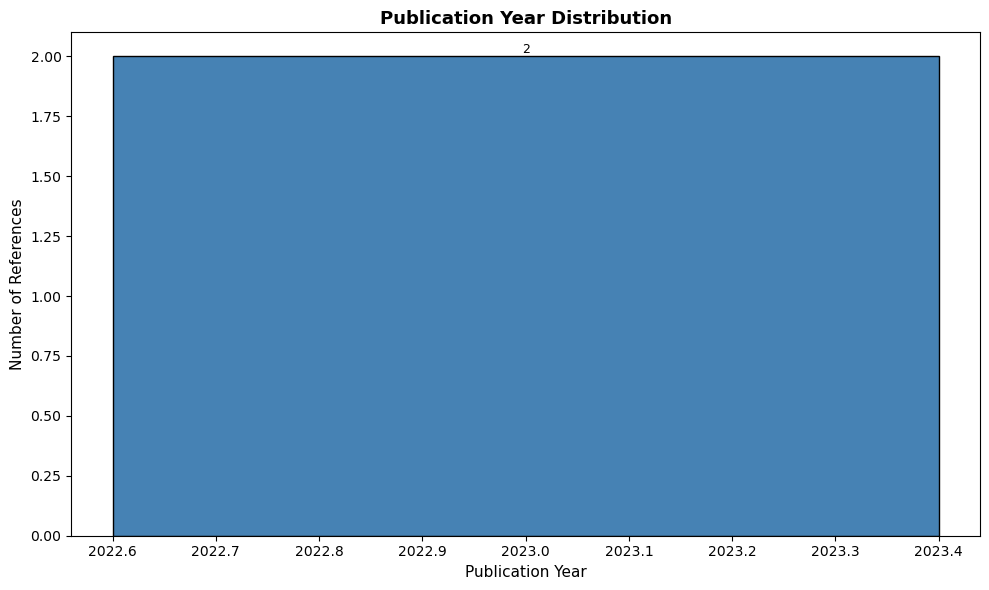


✅ Analytics complete!



In [76]:
# Publication Year Analytics

# ============================================
# IMPORT VISUALIZATION LIBRARIES
# ============================================

try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except ImportError:
    print("⚠️ matplotlib not installed. Installing now...")
    %pip install matplotlib
    import matplotlib.pyplot as plt
    %matplotlib inline

from collections import Counter

# ============================================
# ANALYTICS FUNCTIONS
# ============================================

def extract_years_from_references(references: List[Dict[str, Any]]) -> List[int]:
    """Extract valid publication years from references."""
    years = []
    for ref in references:
        year_str = str(ref['meta'].get('year', 'n.d.')).strip()
        if year_str.isdigit():
            year = int(year_str)
            if 1900 <= year <= 2100:
                years.append(year)
    return years


def create_year_bar_chart(years: List[int]) -> None:
    """Create a simple bar chart of publication year counts."""
    if not years:
        print("⚠️ No valid years to visualize")
        return
    
    # Count occurrences of each year
    year_counts = Counter(years)
    sorted_years = sorted(year_counts.keys())
    counts = [year_counts[year] for year in sorted_years]
    
    # Create bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_years, counts, color='steelblue', edgecolor='black')
    
    # Labels and title
    plt.xlabel('Publication Year', fontsize=11)
    plt.ylabel('Number of References', fontsize=11)
    plt.title('Publication Year Distribution', fontsize=13, fontweight='bold')
    
    # Add count labels on bars
    for year, count in zip(sorted_years, counts):
        plt.text(year, count, str(count), ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()


def display_year_statistics(years: List[int]) -> None:
    """Display publication year statistics."""
    if not years:
        print("⚠️ No valid years found")
        return
    
    print("\n" + "="*50)
    print("📊 PUBLICATION YEAR STATISTICS")
    print("="*50)
    print(f"\nTotal References: {len(years)}")
    print(f"Earliest Year:    {min(years)}")
    print(f"Latest Year:      {max(years)}")
    print(f"Year Range:       {max(years) - min(years)} years")
    print(f"Average Year:     {sum(years) / len(years):.1f}")
    print("="*50)


# ============================================
# MAIN EXECUTION
# ============================================

print("╔══════════════════════════════════════════════════╗")
print("║       Publication Year Analytics                ║")
print("╚══════════════════════════════════════════════════╝\n")

if 'COLLECTED_REFERENCES' not in globals() or len(COLLECTED_REFERENCES) == 0:
    print("⚠️  No references collected yet!")
    print("\n💡 Run Cell 10 with ADD_TO_COLLECTION = True to collect references")
else:
    # Extract years
    years = extract_years_from_references(COLLECTED_REFERENCES)
    
    if years:
        # Show statistics
        display_year_statistics(years)
        
        # Show bar chart
        print("\n📈 Generating bar chart...\n")
        create_year_bar_chart(years)
        
        print("\n✅ Analytics complete!")
    else:
        print("⚠️ No valid publication years found in references")

print("\n" + "="*50)